**ENLR**

This section contains the details to get the radius of ENLR.

In [1]:
%matplotlib inline
# autoload the package, for debuge purpose
%load_ext autoreload
%autoreload 2

# import modules and plot setting
import numpy as np
from matplotlib import pyplot as plt
from astropy.table import Table
import datetime
from astropy.table import Table
from astropy.io import fits
from mangatools.manga import MaNGA
from mangatools.maps import Maps
from mangatools import utils

today = datetime.date.today().isoformat()

# set the display properties

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')

# customize the warning message
import warnings
warnings.filterwarnings("default") # default or ignore
from astropy import log
log.setLevel('ERROR')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Data relese: MPL-8, configure: mangatools/config.py
Global SAS directory is /Volumes/Lacie2


# Testing PSF modeling of MaNGA

In [21]:
from astropy.io import fits
from scipy.ndimage import binary_closing, binary_opening
from matplotlib import colors
from photutils.isophote import Ellipse, EllipseSample
from photutils.isophote import EllipseGeometry
from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans
from photutils import EllipticalAperture

# get the PSF profile from the standard star
hdu_star = fits.open('/Volumes/Lacie2/mangawork/manga/spectro/redux/v2_5_3/7495/stack/manga-7495-1902-LOGCUBE.fits.gz')
flux_star = hdu_star['GPSF'].data * 100

x0 = np.arange(0, flux_star.shape[1])
y0 = np.arange(0, flux_star.shape[0])

sma, eps, pa = 4., 0.1, 0
geometry = EllipseGeometry(x0=x0.mean(), y0=y0.mean(), sma=sma, eps=eps, pa=pa)
ellipse = Ellipse(flux_star, geometry, threshold=0.01)
isolist = ellipse.fit_image(linear=False, step=0.1)#, sclip=2., nclip=3)


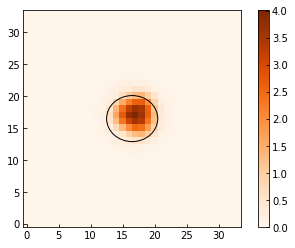

In [22]:
aper = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma,
                           geometry.sma*(1 - geometry.eps),
                           geometry.pa)
plt.imshow(flux_star, origin='lower')
plt.colorbar()
aper.plot(color='black')

In [57]:
isolist.sma

array([0.        , 0.54052228, 0.59457451, 0.65403196, 0.71943516,
       0.79137868, 0.87051654, 0.9575682 , 1.05332502, 1.15865752,
       1.27452327, 1.4019756 , 1.54217316, 1.69639047, 1.86602952,
       2.05263247, 2.25789572, 2.48368529, 2.73205382, 3.0052592 ,
       3.30578512, 3.63636364, 4.        , 4.4       , 4.84      ,
       5.324     , 5.8564    , 6.44204   , 7.086244  , 7.7948684 ])

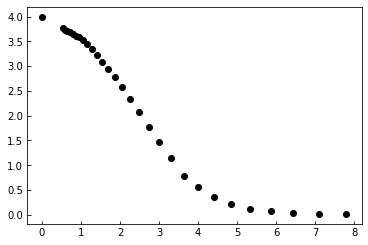

In [23]:
plt.plot(isolist.sma, isolist.intens, 'ko')

     fun: 4.089219051008117e-09
     jac: array([0.00191957, 0.00099514, 0.0028515 , 0.00017537])
 message: 'Optimization terminated successfully.'
    nfev: 40
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([0.69727946, 0.90358209, 0.26899273, 1.85719915])


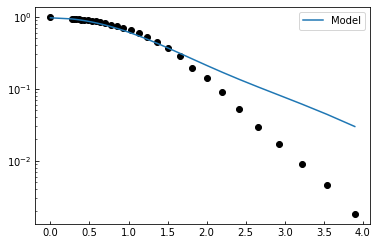

In [62]:
# Two Gaussian modeled PSF
#PSF (r) = A_1 exp( -r^2/(2 sigma_1^2) ) + A_2 exp( -r^2/(2 sigma_2^2) )
from scipy import optimize, signal

def psfmodel(x, r):
    # x: A, sigma1, sigma2
    return x[0] * np.exp(-r**2/(2*x[1]**2)) + x[2] * np.exp(-r**2/(2*x[3]**2))

if True:
    r = isolist.sma * 0.5 
    y = isolist.intens / np.max(isolist.intens)
    x0 = (0.8, 1, 0.2, 2)
    cost_fun = lambda x, r, y: np.sum(psfmodel(x, r) - y)**2
   
    res_lsq = optimize.minimize(np.sum(cost_fun), x0, args=(r, y), 
                                method='SLSQP', options={'disp':False})
print(res_lsq)
if 1:
    plt.figure()
    plt.semilogy(r, y, 'ko')
    plt.plot(r, psfmodel(res_lsq.x, r), label='Model')
    plt.legend()

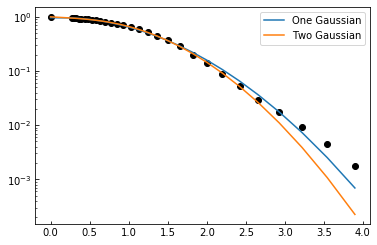

In [64]:
from astropy.modeling import models, fitting


#plt.semilogy(tab_star['SMA'] * 0.1 * 3.4 * 0.145779 / 0.6, tab_star['INTENS']/max(tab_star['INTENS']), ':')
if True:
    x = isolist.sma * 0.5 #+ 1e-4*np.random.randn(len(isolist.sma))
    y = isolist.intens / np.max(isolist.intens)
    g_init1 = models.Gaussian1D(amplitude=1, mean=0, stddev=1)
    g_init2 = models.Gaussian1D(amplitude=0.8, mean=0, stddev=1) + models.Gaussian1D(amplitude=0.2, mean=0, stddev=2.)
    fit_g1 = fitting.LevMarLSQFitter()
    fit_g2 = fitting.LevMarLSQFitter()
    g1 = fit_g1(g_init1, x, y)
    g2 = fit_g1(g_init2, x, y)
    #print(g1.parameters)
    #print(g.stddev.value * 2.355 )
    #liu2013_psf_FWHM.append(g.stddev_1.value * 2.35482)
if 1:
    plt.figure()
    plt.semilogy(x, y, 'ko')
    #plt.plot(x, psf_new(x, g.parameters), 'r', lw=4)
    plt.plot(x, g1(x), label='One Gaussian')
    plt.plot(x, g2(x), label='Two Gaussian')
    #plt.ylim(0.01, 1.1)
    plt.legend()

# Elliptical Isophot Fitting

In [5]:
# functions for do Monte-Carlo simulation for map
from numpy import ma
import numpy as np


def mock_map(sigma, repeats=1000):
    # generate mock error map for give sigma map
    try:
        a, b = sigma.shape
    except:
        return 0
    noise_map = np.zeros((repeats, a, b))
        
    for i in range(a):
        for j in range(b):
            noise_map[:,i,j] = np.random.randn(repeats) * sigma[i,j]
    if ma.is_masked(sigma):
        mask = np.repeat(sigma.mask[np.newaxis, :,:], repeats, axis=0)
        return ma.masked_array(noise_map, mask=mask)
    return noise_map

In [10]:
### Define functions for ellispe fitting
# History:
#   2018-10-05: add history
#   2019-06025: make the program kill itself after a give time

from astropy.io import fits
from scipy.ndimage import binary_closing, binary_opening
from matplotlib import colors
from photutils.isophote import Ellipse, EllipseSample
from photutils.isophote import EllipseGeometry
from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans
from photutils import EllipticalAperture
import signal 

def handler(signum, frame):
    print('Out of time!')
    raise Exception('Out of time!')

def fitEllipse(fmap, init='auto', step=0.2, plot=False, ax=None, n=5,
               fs=8, mini=False, showColorbar=True, showContour=True,
               lw=1, maxiter=1000, quiet=False, runtime=10):
    """for manga data, 0.5 arcsec for each pixels
    fmap: flux map
    init: [sma, eps, pa]
    ellipse: 'auto': using the Ellipse fitting algrithm in photoutil
             'annuli': fitting using the different Re annuli
    """
    if runtime:
        signal.signal(signal.SIGALRM, handler)
        signal.alarm(runtime)
        
    if not quiet:
        print('init:', init)
    # get the length and width of the flux map
    x0 = np.arange(0, fmap.shape[0])
    y0 = np.arange(0, fmap.shape[1])
    # get the approximate radius of non-zero flux map
    rx, ry = np.where(fmap > 0) # index equal to the pixel size
    r_max = np.max([np.abs(rx - x0.mean()), np.abs(rx - y0.mean())])
    fitted = False
    
    if not isinstance(init, str):
        try:
            sma, eps, pa = init
            geometry = EllipseGeometry(x0=x0.mean(), y0=y0.mean(), sma=sma, eps=eps, pa=pa)
            ellipse = Ellipse(fmap, geometry, threshold=0.01)
            isolist = ellipse.fit_image(linear=True, step=step)#, sclip=2., nclip=3)
        except:
            if not quiet:
                print('Initial value fit failed, change to auto fit')
            init = 'auto'
            isolist = None

        if isolist and len(isolist.intens) > 5:
            fitted = True
            
    if init == 'auto' and not fitted:
        # roughly go throgh different initial value
        if not quiet:
            print('guess initial value by given range')
        for sma in np.arange(3, r_max, 0.2):
            for eps in np.arange(0.2, 1., 0.2):
                for pa in np.arange(0, np.pi, 0.5):
                    #print("Parameter:", sma, eps, pa)
                    geometry = EllipseGeometry(x0=x0.mean(), y0=y0.mean(), sma=sma, eps=eps, pa=pa)
                    ellipse = Ellipse(fmap, geometry, threshold=0.01)
                    try: # some may failed to fit
                        isolist = ellipse.fit_image(linear=True, step=step)#, sclip=2., nclip=3)
                    except:
                        continue
                    #print("len(intens):", len(isolist.intens))
                    if len(isolist.intens) > 5:
                        fitted = True
                        init = [sma, eps, pa]
                        break
                if fitted:
                    break
            if fitted:
                break
        if not fitted:
            if not quiet:
                print("auto fit failed")
            init = 'random'
        
        
    if init == 'random' and not fitted:
        if not quiet:
            print('guess initial value by random number')
        itern = 1
        intens = []
        try:
            while len(intens) < 5:
                if itern > maxiter:
                    if not quiet:
                        print('maximum iteration exceed {}!'.format(maxiter))
                    break
                sma = np.random.rand() * r_max
                eps = np.random.rand()
                pa = np.random.rand() * np.pi
                geometry = EllipseGeometry(x0=x0.mean(), y0=y0.mean(), sma=sma, eps=eps, pa=pa)
                ellipse = Ellipse(fmap, geometry, threshold=0.01)
                try: # some may failed to fit
                    isolist = ellipse.fit_image(linear=True, step=step)#, sclip=2., nclip=3)
                    intens = isolist.intens
                except:
                    intens = []
                itern += 1
        except KeyboardInterrupt:
            pass
        if itern >= maxiter:
            if not quiet:
                print("Faild all tries!")
            return 'auto', []
        fitted = True
    
    if fitted == True:
        init = [sma, eps, pa]
        if not quiet:
            print("Success:", [sma, eps, pa])

    if plot:
        if ax == None:
            fig = plt.figure()
            ax = fig.add_subplot(111)
        ccx = (x0 - x0.mean())*0.5
        ccy = (y0 - y0.mean())*0.5
        #im = ax.pcolormesh(ccx, ccy, fmap) #, cmap='viridis')
        #sb = 4 * O3_corr / 10
        im = ax.pcolormesh(ccx, ccy, fmap, norm=colors.LogNorm(vmin=0.1, vmax=fmap.max()), cmap='Oranges')
        x = isolist.sma * 0.5
        valid = (isolist.valid == 1) & (isolist.intens > 0.001) & (isolist.stop_code < 3)
        print('x[valid].max()', x[valid].max())
        #smas = np.linspace(0.5, x[valid].max(), n)
        # plot the fitted ellipse
        for sma in x[valid][1::2]:
            iso = isolist.get_closest(sma)
            fx, fy, = iso.sampled_coordinates()
            #print(fx)
            fx = (fx - x0.mean())*0.5
            fy = (fy - y0.mean())*0.5
            ax.plot(fx, fy, color='blue', alpha=1, lw=0.5)
        if mini:
            ax.tick_params(axis='both', which='major', labelsize=fs)
            # plot.tick_params(axis='both', which='minor', labelsize=8)
            # ax.set_xticklabels([])
            # ax.set_yticklabels([])
        else:
            ax.set_title('Ellipse Fitting', fontsize=fs)
            ax.set_ylabel('arcsec', fontsize=fs)
            ax.set_xlabel('arcsec', fontsize=fs)
        if showContour:
            cs = ax.contour(ccx, ccy, fmap, levels=[1], colors='r', extent=extent, linewidths=0.5)
            #plt.clabel(cs, inline=1, fontsize=5, fmt='%1.1f')
            cbar = plt.colorbar(im, ax=ax[i, 3], fraction=0.056, pad=0.04, ticks=[0.1, 1, 10], orientation='vertical')
            cbar.ax.tick_params(labelsize=4)
            cbar.ax.set_title(r'$\quad\quad\times 10^{-16}$', fontsize=4, pad=0.2)
            cbar.ax.tick_params(axis='both', which='major', labelsize=2)
            cbar.ax.tick_params(axis='both', which='minor', labelsize=0.5)
            cbar.ax.set_yticklabels(['0.1', '1', '10'])  # horizontal colorbar
            #extent = [ccx.min(), ccx.max(), ccy.min(), ccy.max()]
            #cs = ax.contour(ccx, ccy, fmap, levels=[1, 3,10,100], colors='r', extent=extent, alpha=0.5)
            #plt.clabel(cs, inline=1, fontsize=5, fmt='%1.1f')
        if showColorbar:
            cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            cbar.ax.tick_params(labelsize=fs)

    return init, isolist
    
def fit_rings(r, fmap, Re, step=0.2, plot=True):
    #x0 = np.arange(0, fmap.shape[0])
    #y0 = np.arange(0, fmap.shape[1])
    sma = []
    intens = []
    intens_err = []
    for r_ring in np.arange(0, Re, step):
        r_select = (r_ring < r) & (r < r_ring + step)
        sma.append(r_ring + step/2)
        intens.append(np.mean(fmap[r_select]))
        intens_err.append(np.std(fmap[r_select]))
    return np.array(sma), np.array(intens), np.array(intens_err)

## Single Case Demonstration

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide


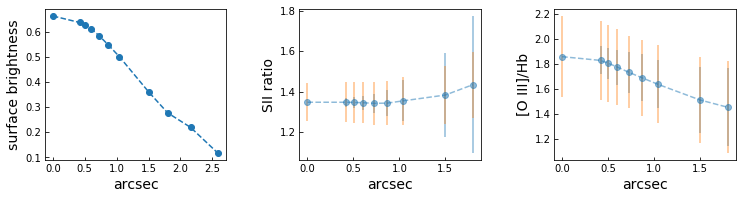

In [4]:
# demo the ellipse fitting
# History:
#   2018-10-22: first release
#   2019-01-03: using new fitting map data
#   

from mangatools.fitmaps import FitMaps
#fm_dir = '/Volumes/Lacie2/ENLR/fitmaps/'
#fm_binned_dir = '/Volumes/Lacie2/ENLR/fitmaps_binned/'
fm_dir = '/Volumes/Lacie2/fitmaps/fitmap/' #set to your local folder
fm_binned_dir = '/Volumes/Lacie2/fitmaps/fitmap2/' #set to your local folder

set_matplotlib_formats('png')
quiet = True
useHaEW = True

plateifu = '9893-6102'
m = Maps(plateifu)
agn, cp, sf, *others = m.bptregion()
if useHaEW:
    HaEW_region = m.line_ew('Ha-6564') > 3
    agn = agn & HaEW_region


fm = FitMaps(plateifu, fitmaps_dir=fm_dir, fitmaps_binned_dir=fm_binned_dir)
O3_corr, O3_corr_err = fm.O3map()
O3_agn = np.zeros(agn.shape)
O3_agn[agn] = O3_corr[agn]

sample_time = 0
intens_list = []
agn = binary_opening(binary_closing(agn, iterations=2), iterations=2)

O3_agn = np.zeros(agn.shape)
O3_agn[agn] = O3_corr[agn]
init0, isolist = fitEllipse(O3_agn, init='auto')
valid = (isolist.stop_code == 0) #& (isolist.valid == 1)
#valid = np.ones_like(isolist.sma)
sma_base = isolist.sma[valid]
intens_list.append(isolist.intens[valid].tolist())


if True: # get the S2 ratio profile
    x0 = np.arange(0, O3_agn.shape[0])
    y0 = np.arange(0, O3_agn.shape[1])
    S2_1 = fm.line('[SII]6716')
    S2_2 = fm.line('[SII]6731')
    S2_ratio = S2_1[0] / S2_2[0]
    S2_ratio_noise = np.sqrt((S2_1[1]/S2_2[0])**2 + (S2_2[1]*S2_1[0]/S2_2[0]**2)**2)
    S2_sma_list = []
    S2_ratio_list = []
    S2_ratio_err_list = []
    S2_ratio_noise_list = []
    sma_fixed = sma_base
    sma_fixed[0] = 0.001 # fixed the first zero sma
    for sma, eps, pa in zip(sma_fixed, isolist.eps[valid], isolist.pa[valid]):
        #print(sma, eps, pa)
        densmap = EllipseSample(S2_ratio, sma, eps=eps, position_angle=pa, x0=x0.mean(), y0=y0.mean())
        densmap_err = EllipseSample(S2_ratio_noise, sma, eps=eps, position_angle=pa, x0=x0.mean(), y0=y0.mean())
        ellipse_sample = densmap.extract()
        ellipse_noise_sample = densmap_err.extract()
        S2_sma_list.append(sma)
        S2_ratio_list.append(np.mean(ellipse_sample[2]))
        S2_ratio_err_list.append(np.std(ellipse_sample[2]))
        S2_ratio_noise_list.append(np.median(ellipse_noise_sample[2]))

if True: # get the ionization ratio profile
    x0 = np.arange(0, O3_agn.shape[0])
    y0 = np.arange(0, O3_agn.shape[1])
    OIII = fm.line('[OIII]5008')
    Hb = fm.line('Hbeta')
    ioni_ratio = OIII[0] / Hb[0]
    ioni_ratio_noise = np.sqrt((OIII[1]/Hb[0])**2 + (Hb[1]*OIII[0]/Hb[0]**2)**2)
    ioni_sma_list = []
    ioni_ratio_list = []
    ioni_ratio_err_list = []
    ioni_ratio_noise_list = []
    sma_fixed = sma_base
    sma_fixed[0] = 0.001 # fixed the first zero sma
    for sma, eps, pa in zip(sma_fixed, isolist.eps[valid], isolist.pa[valid]):
        #print(sma, eps, pa)
        densmap = EllipseSample(ioni_ratio, sma, eps=eps, position_angle=pa, x0=x0.mean(), y0=y0.mean())
        densmap_noise = EllipseSample(ioni_ratio_noise, sma, eps=eps, position_angle=pa, x0=x0.mean(), y0=y0.mean())
        ellipse_sample = densmap.extract()
        ellipse_noise_sample = densmap_noise.extract()
        ioni_sma_list.append(sma)
        ioni_ratio_list.append(np.mean(ellipse_sample[2]))
        ioni_ratio_err_list.append(np.std(ellipse_sample[2]))
        ioni_ratio_noise_list.append(np.median(ellipse_noise_sample[2]))
        
for i in range(sample_time):
    #print(i)
    # add random gaussian error into the O3 map
    O3 = O3_corr + np.random.randn(*O3_corr_err.shape) * np.abs(O3_corr_err)
    O3_agn = np.zeros(agn.shape)
    O3_agn[agn] = O3[agn]
    init, isolist = fitEllipse(O3, init=init0, quiet=quiet)
    if len(isolist.sma) < 5:
        print("Failed fitting!")
        continue
    intens = np.interp(sma_base, isolist.sma, isolist.intens)
    intens_list.append(intens.tolist())

x = sma_base * 0.5 # scale to real size
y = np.mean(intens_list, axis=0)
y_err = np.std(intens_list, axis=0)

if True:
    fig = plt.figure(figsize=(12, 3))
    plt.subplots_adjust(left=0.1, right=0.9, top=0.8, bottom=0.1, wspace=0.4, hspace=0.14)
    ax = fig.subplots(1, 3)
    #ax[0].plot(x, y, 'o')
    ax[0].errorbar(x, y, yerr=y_err, marker='o', linestyle='--')
    ax[0].set_xlabel('arcsec', fontsize=14)
    ax[0].set_ylabel('surface brightness', fontsize=14)
    ax[1].errorbar(0.5*np.array(S2_sma_list), np.array(S2_ratio_list), yerr=S2_ratio_err_list, marker='o', linestyle='--', alpha=0.5)
    ax[1].errorbar(0.5*np.array(S2_sma_list), np.array(S2_ratio_list), yerr=S2_ratio_noise_list, marker=None, linestyle='None', alpha=0.5)
    ax[1].set_xlabel('arcsec', fontsize=14)
    ax[1].set_ylabel('SII ratio', fontsize=14)
    ax[2].errorbar(0.5*np.array(ioni_sma_list), np.array(ioni_ratio_list), yerr=ioni_ratio_err_list, marker='o', linestyle='--', alpha=0.5)
    ax[2].errorbar(0.5*np.array(ioni_sma_list), np.array(ioni_ratio_list), yerr=ioni_ratio_noise_list, marker=None, ls='None', alpha=0.5)
    ax[2].set_xlabel('arcsec', fontsize=14)
    ax[2].set_ylabel('[O III]/Hb', fontsize=14)
    plt.show()
    set_matplotlib_formats('png')

## Statistics

In [5]:
# Statistics, no density and ionization
# 
# History:
#   2019-01-30: not save ratio but the line flux instead
#   2019-05-16: run for submission
#
from mangatools.fitmaps import FitMaps
fm_dir = '/Volumes/Lacie2/fitmaps/fitmap/'
fm_binned_dir = '/Volumes/Lacie2/fitmaps/fitmap2/'
#fm_dir = '/Volumes/DATA/fitmap/' #set to your local folder
#fm_binned_dir = '/Volumes/DATA/fitmap2/' #set to your local folder

warnings.filterwarnings("ignore")
log.setLevel('ERROR')

targets = Table.read('data/AGNs-2019-04-26.dat', format='ascii')
quiet = 1
useHaEW = True
s2_ratio = False
ion_ratio = False
sample_time = 100
targets = targets
total_num = len(targets)

hdr = fits.Header()
hdr['AUTHOR'] = 'Jianhang Chen'
hdr['DATE'] = '{}'.format(today)
hdr['COMMENT'] = "Ellipse fittting of the [OIII] surface brightness isophote"
primary_hdu = fits.PrimaryHDU(header=hdr)

hdu_list = [primary_hdu]

for idx, plateifu in enumerate(targets['plateifu']):
    idx = idx
    #print(idx+base, plateifu)
    m = Maps(plateifu)
    agn, cp, sf, *others = m.bptregion()
    if useHaEW:
        HaEW_region = m.line_ew('Ha-6564') > 3
        agn = agn & HaEW_region
    mask = agn | cp | sf
    #mask = np.ones_like(agn)
    #mask[23, 23] = 0
    
    
    intens_list = []
    #init = 'auto' #auto guess the initial value
    agn = binary_opening(binary_closing(agn, iterations=2), iterations=2)

    try:
        fm = FitMaps(plateifu, fitmaps_dir=fm_dir, fitmaps_binned_dir=fm_binned_dir)
        O3_corr, O3_corr_err = fm.O3map()
    except:
        continue
    O3_agn = np.zeros(agn.shape)
    O3_agn[agn] = O3_corr[agn]
    try:
        init0, isolist = fitEllipse(O3_agn, init='auto', quiet=quiet)
    except:
        continue
    valid = (isolist.stop_code == 0) & (isolist.valid == 1)
    sma_base = isolist.sma[valid]
    intens_list.append(isolist.intens[valid].tolist())

    if s2_ratio: # get the S2 ratio profile
        x0 = np.arange(0, O3_agn.shape[0])
        y0 = np.arange(0, O3_agn.shape[1])
        S2_1 = fm.line('[SII]6716')
        S2_2 = fm.line('[SII]6731')
        S2_ratio = S2_1[0] / S2_2[0]
        S2_1_list = []
        S2_1_err_list = []
        S2_2_list = []
        S2_2_err_list = []
        sma_fixed = sma_base
        sma_fixed[0] = 0.001 # fixed the first zero sma
        for sma, eps, pa in zip(sma_fixed, isolist.eps[valid], isolist.pa[valid]):
            #print(sma, eps, pa)
            S2_1_map = EllipseSample(S2_1[0], sma, eps=eps, position_angle=pa, x0=x0.mean(), y0=y0.mean())
            S2_1_err_map = EllipseSample(S2_1[1], sma, eps=eps, position_angle=pa, x0=x0.mean(), y0=y0.mean())
            S2_2_map = EllipseSample(S2_2[0], sma, eps=eps, position_angle=pa, x0=x0.mean(), y0=y0.mean())
            S2_2_err_map = EllipseSample(S2_2[1], sma, eps=eps, position_angle=pa, x0=x0.mean(), y0=y0.mean())
            S2_1_sample = S2_1_map.extract()
            S2_1_err_sample = S2_1_err_map.extract()
            S2_2_sample = S2_2_map.extract()
            S2_2_err_sample = S2_2_err_map.extract()
            S2_1_tmp = np.sum(S2_1_sample[2]) / len(S2_1_sample[2])
            S2_1_tmp_err = np.sqrt(np.sum(S2_1_err_sample[2]**2))
            S2_2_tmp = np.sum(S2_2_sample[2]) / len(S2_2_sample[2])
            S2_2_tmp_err = np.sqrt(np.sum(S2_2_err_sample[2]**2))
            S2_1_list.append(S2_1_tmp)
            S2_1_err_list.append(S2_1_tmp_err)
            S2_2_list.append(S2_2_tmp)
            S2_2_err_list.append(S2_2_tmp_err)

    if ion_ratio: # get the ionization ratio profile
        x0 = np.arange(0, O3_agn.shape[0])
        y0 = np.arange(0, O3_agn.shape[1])
        OIII = fm.line('[OIII]5008')
        Hb = fm.line('Hbeta')
        OIII_list = []
        OIII_err_list = []
        Hb_list = []
        Hb_err_list = []
        sma_fixed = sma_base
        sma_fixed[0] = 0.001 # fixed the first zero sma
        for sma, eps, pa in zip(sma_fixed, isolist.eps[valid], isolist.pa[valid]):
            #print(sma, eps, pa)
            OIII_map = EllipseSample(OIII[0], sma, eps=eps, position_angle=pa, x0=x0.mean(), y0=y0.mean())
            OIII_err_map = EllipseSample(OIII[1], sma, eps=eps, position_angle=pa, x0=x0.mean(), y0=y0.mean())
            OIII_sample = OIII_map.extract()
            OIII_err_sample = OIII_err_map.extract()
            Hb_map = EllipseSample(Hb[0], sma, eps=eps, position_angle=pa, x0=x0.mean(), y0=y0.mean())
            Hb_err_map = EllipseSample(Hb[1], sma, eps=eps, position_angle=pa, x0=x0.mean(), y0=y0.mean())
            Hb_sample = Hb_map.extract()
            Hb_err_sample = Hb_err_map.extract()
            OIII_tmp = np.sum(OIII_sample[2]) / len(OIII_sample[2])
            OIII_tmp_err = np.sqrt(np.sum(OIII_err_sample[2]**2))
            Hb_tmp = np.sum(Hb_sample[2]) / len(Hb_sample[2])
            Hb_tmp_err = np.sqrt(np.sum(Hb_err_sample[2]**2))
            OIII_list.append(OIII_tmp)
            OIII_err_list.append(OIII_tmp_err)
            Hb_list.append(Hb_tmp)
            Hb_err_list.append(Hb_tmp_err)
            
    for i in range(sample_time):
        #print(i)
        # add random gaussian error into the O3 map
        O3 = O3_corr + np.random.randn(*O3_corr_err.shape) * np.abs(O3_corr_err)
        O3_agn = np.zeros(agn.shape)
        O3_agn[agn] = O3[agn]
        init, isolist = fitEllipse(O3_agn, init=init0, quiet=quiet)
        if len(isolist) < 5:
            if not quiet:
                print("Skipped isolist:", isolist.sma)
                print("Skip failed fitting")
            continue
        intens = np.interp(sma_base, isolist.sma, isolist.intens)
        intens_list.append(intens.tolist())

    sma = sma_base * 0.5 # scale to real size
    intens = np.mean(intens_list, axis=0)
    intens_err = np.std(intens_list, axis=0)
    
    hdr_bin = fits.Header()
    hdr_bin['is_limit'] = targets['is_limit'][idx]
    hdr_bin['Re'] = m.elpetro_r

    c1 = fits.Column(name='sma', array=sma, format='D') # double float
    c2 = fits.Column(name='intens', array=intens, format='D') # doubel float
    c3 = fits.Column(name='intens_err', array=intens_err, format='D') # double float
    column_list = [c1, c2, c3]
    if s2_ratio:
        c4 = fits.Column(name='S2_1', array=np.array(S2_1_list), format='D')
        c5 = fits.Column(name='S2_2', array=np.array(S2_2_list), format='D')
        c6 = fits.Column(name='S2_1_err', array=np.array(S2_1_err_list), format='D')
        c7 = fits.Column(name='S2_2_err', array=np.array(S2_2_err_list), format='D')
        column_list.append(c4)
        column_list.append(c5)
        column_list.append(c6)
        column_list.append(c7)
    if ion_ratio:
        c8 = fits.Column(name='OIII', array=np.array(OIII_list), format='D')
        c9 = fits.Column(name='OIII_err', array=np.array(OIII_err_list), format='D')
        c10 = fits.Column(name='Hb', array=np.array(Hb_list), format='D')
        c11 = fits.Column(name='Hb_err', array=np.array(Hb_err_list), format='D')
        column_list.append(c8)
        column_list.append(c9)
        column_list.append(c10)
        column_list.append(c11)
    bintable_hdu = fits.BinTableHDU.from_columns(column_list, 
                                                 name=plateifu, header=hdr_bin)
    hdu_list.append(bintable_hdu)
    utils.processBar(total_num, idx+1)
hdus = fits.HDUList(hdu_list)
hdus.writeto('data/Ellipse_Fitting-{}.fits'.format(today), overwrite=True)
print('Done! Write into file data/Ellipse_Fitting-{}.fits'.format(today))
#warnings.filterwarnings("default")

[##############--------------------------] 34% Out of time!
[############################------------] 71% Out of time!
[#################################-------] 84% Out of time!
[#####################################---] 91% Out of time!
[#####################################---] 92% Out of time!
[########################################] 100% 
Done! Write into file data/Ellipse_Fitting-2019-06-26.fits


# Surface Brightness Profile Fitting

1. Just fitting use one or two Sersic profile
2. Add the convolution into the fitting

## Single Testing with De-convolution

x1: [1.17555508 0.30637745 0.57688639] x2: [2.30659984 1.77404898 1.6088943 ]
undetected!
logR_fsb1: -3.0583177923724567 error: 434294.4819032518
deconvlution undetected!


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: divide by zero encountered in true_divide


deconvlution undetected!
deconvlution undetected!
deconvlution undetected!
deconvlution undetected!
deconvlution undetected!
deconvlution undetected!
deconvlution undetected!
deconvlution undetected!
deconvlution undetected!
R: -1.0583177923724567 error: 0.0


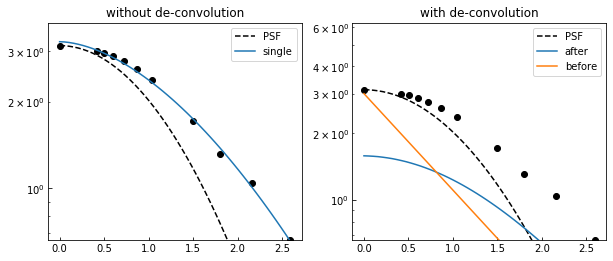

In [69]:
### New version, test
# single test, update for put the interpolate into the model
# global value
import numpy as np
from scipy import optimize, signal
from matplotlib import pyplot as plt
from ppxf import capfit

def psf_func(r, amplitude=0, mean=0, stddev=0):
    return amplitude * np.exp(-(r-mean)**2/(2*stddev**2))

def psf_kernel(fwhm, interv=1, data_points=50):
    edge = data_points/(2*interv)
    r = np.arange(-edge, edge+interv, interv)
    sigma = fwhm/2.35482
    return np.exp(-r**2/(2*sigma**2))

def fmodel_conv(x, r, basemodel, psf_fwhm=None, points=50, scale_factor=1.5):
    # used for convolution
    r_interp = np.linspace(r.min(), 1.5*r.max(), points)
    flux = basemodel(x, r_interp)
    psf = psf_kernel(psf_fwhm, r_interp[1]-r_interp[0])
    flux_sym = np.array([flux[::-1], flux]).flatten()
    flux_conv = signal.fftconvolve(flux_sym, psf, mode='same')/np.sum(psf)
    return np.interp(r, r_interp, flux_conv[len(flux_sym)//2:])

if True: # same like following, but show the two component seperately    
    eps = 1e-8 # error value, or value used for handling zero
    plot = True
    SB = 10
    plateifu = '9893-6102'
    m = Maps(plateifu)
    z = m.z
    sb_corr = (1+z)**4
    agn, cp, sf, *others = m.bptregion()
    psf = m.psf
    agn_fraction = np.sum(agn) / np.sum(agn | cp | sf)
    agn_pixels = np.sum(agn)
    with fits.open('data/Ellipse_Fitting-2019-05-16.fits') as f:
        data = f[plateifu].data
        header = f[plateifu].header
        # ignore the first point
        r = data['sma'] + np.random.randn(len(data['sma']))*1e-4
        I = data['intens'] * 4 * sb_corr + np.random.randn(len(data['sma']))*1e-4
        I_err = data['intens_err'] * 4 * sb_corr
        logI = np.log(I)
        logI_err = I_err/I + 1e-6
    
    # define the model
    baseModel = lambda x, r: np.exp(x[0] - x[1] * r**(1/x[2]))
    # Fitting, logrithm the flux
    #fitModel = lambda x, r: np.log10(baseModel(x, r))
    
    # initial value and bounds
    x0 = (logI[1], 1, 1)
    bounds=((0, np.inf), (0.01, 10), (0.5, 10))
    
    #********* fit without de-convlolution *************#
    # used the logscale of y, to optimize the fitting
    cost_fun1 = lambda x, r, logy, logy_err: \
                np.sum((np.log(baseModel(x, r)) - logy)**2/(logy_err)**2)
   
    res_lsq1 = optimize.minimize(cost_fun1, x0,
                                 args=(r, logI, logI_err), 
                                 method='L-BFGS-B', options={'disp':False},
                                 jac='2-point', bounds=bounds)
    #res_lsq1 = capfit.capfit(cost_fun1, x0, args=(r, logI, logI_err),
    #                         bounds=np.transpose(bounds))
    #res_lsq = optimize.least_squares(cost_fun, x0, 
    #                                 args=(r, logy, logy_err), 
    #                                 jac='2-point')
    #perror = capfit.cov_err(res_lsq.jac)[1]
    
    #*********** fit with de-convolution ****************#
    cost_fun2 = lambda x, r, logy, logy_err, basemodel, psf_fwhm: \
                np.sum((np.log(fmodel_conv(x, r, basemodel, psf_fwhm)) - logy)**2/logy_err**2)
    res_lsq2 = optimize.minimize(cost_fun2, x0,
                                 args=(r, logI, logI_err, baseModel, psf), 
                                 method='L-BFGS-B', options={'disp':False},
                                 jac='2-point', bounds=bounds)
    #cost_fun2 = lambda x, r, logy, logy_err, basemodel, psf_fwhm: \
    #            (np.log(fmodel_conv(x, r, basemodel, psf_fwhm)) - logy)**2/logy_err**2
    #res_lsq2 = capfit.capfit(cost_fun2, x0, args=(r, logI, logI_err, baseModel, psf),
    #                         bounds=np.transpose(bounds))
    
    if True: # resample to get the fitting error
        sample_times = 10
        R_list = []
        r_extend = np.linspace(r.min(), r.max(), 50)
        gg_fit1 = baseModel(res_lsq1.x, r_extend)
        print('x1:', res_lsq1.x, 'x2:', res_lsq2.x)
        try:
            R_fsb1 = np.max(r_extend[gg_fit1 > SB])
        except:
            R_fsb1 = 1e-6
            print('undetected!')
        logR_fsb1 = np.log10(R_fsb1 * m.arcsec2kpc.value*1000)
        logR_fsb1_err = 1./R_fsb1/np.log(10)
        print('logR_fsb1:', logR_fsb1, 'error:', logR_fsb1_err)
        
        for i in range(sample_times):
            logI = np.log(I + I_err*np.random.randn(len(I)))
            logI_err = I_err/I
            #cost_fun2 = lambda x, r, logy, logy_err, basemodel, psf_fwhm: \
            #            np.sum((np.log(fmodel_conv(x, r, basemodel, psf_fwhm)) - logy)**2/logy_err**2)
            try:
                res_lsq2 = optimize.minimize(cost_fun2, x0,
                                             args=(r, logI, logI_err, baseModel, psf), 
                                             method='L-BFGS-B', options={'disp':False},
                                             jac='2-point', bounds=bounds)
            except:
                print("Failed fitting")
                continue

            #print("gg_fit2", gg_fit2)
            gg_fit2 = fmodel_conv(res_lsq2.x, r_extend, baseModel, psf)
            try:
                R_fsb2 = np.max(r_extend[gg_fit2 > SB])
            except:
                R_fsb2 = 1e-4
                print('deconvlution undetected!')
            logR_fsb2 = np.log10(R_fsb2 * m.arcsec2kpc.value*1000)
            R_list.append(logR_fsb2)
        print("R:", np.mean(R_list), 'error:', np.std(R_list))
        #print(R_list)

    if plot:
        # generate data for plot 
        r_extend = np.linspace(r.min(), r.max(), 50) # for smooth plot
        gauss_psf = psf_func(r_extend, amplitude=I.max(), mean=0, stddev=psf/2.35482)

        fig, ax_list = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

        # show the results of without de-convolution
        gg_fit1 = baseModel(res_lsq1.x, r_extend)
        ax = ax_list[0]
        ax.set_title('without de-convolution')
        ax.semilogy(r, I, 'ko')
        ax.errorbar(r, I, yerr=I_err, marker='None', linestyle='None', color='k')
        ax.plot(r_extend, gauss_psf, 'k--', label='PSF')
        ax.plot(r_extend, gg_fit1, label='single')
        ax.legend()
        ax.set_ylim(I.min(), 1.2*I.max())

        # show the results after convolution
        #xx = np.array(res_lsq2.x) + np.array(res_lsq2.x_err) * np.random.randn(3)
        gg_fit2 = fmodel_conv(res_lsq2.x, r_extend, baseModel, psf)
        gg_fit2_orig = baseModel(res_lsq2.x, r_extend)
        ax = ax_list[1]
        ax.set_title('with de-convolution')
        ax.semilogy(r, I, 'ko')
        ax.plot(r_extend, gauss_psf, 'k--', label='PSF')
        ax.errorbar(r, I, yerr=I_err, marker='None', linestyle='None', color='k')
        ax.plot(r_extend, gg_fit2, label='after')
        ax.plot(r_extend, gg_fit2_orig, label='before')
        ax.set_ylim(I.min(), 2*I.max())
        ax.legend()

In [51]:
print(I_err)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Generate all the Radius of ENLR

In [2]:
# Statistics
# History:
#    2019-01-07: released, just copy single test file, change if True -> for loop
#                and save the fitted data into files
#    2019-02-01: update the initial value and boundary for n (0.5, 10)
#    2019-02-15: change the upper-limit error to 0.1, just for plot purpose

# global value
import numpy as np
from scipy import optimize, signal
from matplotlib import pyplot as plt
from ppxf import capfit
import matplotlib.backends.backend_pdf as mpdf

def psf_func(r, amplitude=0, mean=0, stddev=0):
    return amplitude * np.exp(-(r-mean)**2/(2*stddev**2))

def psf_kernel(fwhm, interv=1, data_points=50):
    edge = data_points/(2*interv)
    r = np.arange(-edge, edge+interv, interv)
    sigma = fwhm/2.35482
    return np.exp(-r**2/(2*sigma**2))

def fmodel_conv(x, r, basemodel, psf_fwhm=None, points=50, scale_factor=1.5):
    # used for convolution
    r_interp = np.linspace(r.min(), 1.5*r.max(), points)
    flux = basemodel(x, r_interp)
    psf = psf_kernel(psf_fwhm, r_interp[1]-r_interp[0])
    flux_sym = np.array([flux[::-1], flux]).flatten()
    flux_conv = signal.fftconvolve(flux_sym, psf, mode='same')/np.sum(psf)
    return np.interp(r, r_interp, flux_conv[len(flux_sym)//2:])


plot = True
save = True
SB = 100
sample_times = 100
quiet = True

excess_num = 0
undetect_num = 0

targets = Table.read('data/AGNs-2019-04-26.dat', format='ascii')

# last_run: 54
# plateifu: 8946-3701
#base = 10
targets = targets[:]

if plot: #plot into file
    pdf = mpdf.PdfPages('results/checkfit-({})-{}.pdf'.format(SB, today))

if save: #save fitting results into file
    fsb_file = open('data/R_fsb-({})-{}.dat'.format(SB, today), 'w')
    fsb_file.write("{} {} {} {} {} {} {} {} {} {} {}\n".format(
        'plateifu', 'logR_fsb1', 'logR_fsb1_err', 'logR_fsb2', 'logR_fsb2_err', \
        'logR_fsb2_orig', 'logR_fsb2_orig_err', 'is_limit', 'agn_fraction', 'agn_pixels', \
        'excess'))
    
for idx, plateifu in enumerate(targets['plateifu']):
    eps = 1e-8 # error value, or value used for handling zero
    if not quiet:
        print(plateifu)
    m = Maps(plateifu)
    psf = m.psf
    z = m.z
    sb_corr = (1+z)**4
    agn, cp, sf, *others = m.bptregion()
    agn_fraction = np.sum(agn) / np.sum(agn | cp | sf)
    agn_pixels = np.sum(agn)
    with fits.open('data/Ellipse_Fitting-2019-05-16.fits') as f:
        try:
            data = f[plateifu].data
            header = f[plateifu].header
        except:
            fsb_file.write("{} {} {} {} {} {} {} {} {} {} {}\n".format(plateifu, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0))
            continue
        
        r = data['sma']
        I = data['intens'] * sb_corr * 4
        I_err = data['intens_err'] * sb_corr * 4
        logI = np.log(I)
        logI_err = I_err/I + eps
        
        # check excess or undetect by given SB
        if I[-1] > SB:
            excess = 1
            excess_num += 1
        else:
            excess = 0
        undetect = False
        if I[0] < SB:
            undetect = True
            undetect_num += 1
            
    # define the model
    baseModel = lambda x, r: np.exp(x[0] - x[1] * r**(1/x[2]))
    
    # initial value and bounds
    x0 = (logI[1], 1, 0.5)
    bounds=((0, np.inf), (0.01, 10), (0.5, 10))
    
    #********* fit without de-convlolution *************#
    # used the logscale of y, to optimize the fitting
    cost_fun1 = lambda x, r, logy, logy_err: \
                np.sum((np.log(baseModel(x, r)) - logy)**2/(logy_err)**2)
   
    res_lsq1 = optimize.minimize(cost_fun1, x0,
                                 args=(r, logI, logI_err), 
                                 method='L-BFGS-B', options={'disp':False},
                                 jac='2-point', bounds=bounds)
    
    #*********** fit with de-convolution ****************#
    cost_fun2 = lambda x, r, logy, logy_err, basemodel, psf_fwhm: \
                np.sum((np.log(fmodel_conv(x, r, basemodel, psf_fwhm)) - logy)**2/logy_err**2)
    res_lsq2 = optimize.minimize(cost_fun2, x0,
                                 args=(r, logI, logI_err, baseModel, psf), 
                                 method='L-BFGS-B', options={'disp':False},
                                 jac='2-point', bounds=bounds)
    
    if save: # save fitted results into file
        r_extend = np.linspace(r.min(), 5*r.max(), 1000) # for smooth plot
        gg_fit1 = baseModel(res_lsq1.x, r_extend)
        gg_fit2 = fmodel_conv(res_lsq2.x, r_extend, baseModel, psf)
        gg_fit2_orig = baseModel(res_lsq2.x, r_extend)
        
        try:
            R_fsb1 = np.max(r_extend[gg_fit1 > SB])
            R_fsb2 = np.max(r_extend[gg_fit2 > SB])
            R_fsb2_orig = np.max(r_extend[gg_fit2_orig > SB])
            has_size = True
        except:
            print('No valid measurment')
            R_fsb1, R_fsb2, R_fsb2_orig = 1e-6, 1e-6, 1e-6
            has_size = False
        logR_fsb1 = np.log10(R_fsb1 * m.arcsec2kpc.value*1000)
        logR_fsb1_err = .5/R_fsb1/np.log(10)
        logR_fsb2 = np.log10(R_fsb2 * m.arcsec2kpc.value*1000)
        logR_fsb2_err = .5/R_fsb2/np.log(10)
        logR_fsb2_orig = np.log10(R_fsb2_orig * m.arcsec2kpc.value*1000)
        logR_fsb2_orig_err = .5/R_fsb2_orig/np.log(10)
        
        if ((np.abs(res_lsq2.x[1] - 10) < 1e-8) or (np.abs(res_lsq2.x[2] - 10) < 1e-8)
            or (np.abs(res_lsq2.x[2] - 0.5) < 1e-8)):
            is_limit = 1
            if not quiet:
                print('is upper limit!')
            logR_fsb2_err = .1
            logR_fsb2_orig_err = .1
        else:
            is_limit = 0
        
            
        if not is_limit and has_size: # resample to get the fitting error
            R_list = []
            R_orig_list = []
            r_extend = np.linspace(r.min(), 5 * r.max(), 1000)
            failed_times = 0
            for i in range(sample_times):
                logI = np.log(I + I_err*np.random.randn(len(I)))
                logI_err = I_err/I + eps
                try:
                    res_lsq2 = optimize.minimize(cost_fun2, x0,
                                                 args=(r, logI, logI_err, baseModel, psf), 
                                                 method='L-BFGS-B', options={'disp':False},
                                                 jac='2-point', bounds=bounds)
                    gg_fit2 = fmodel_conv(res_lsq2.x, r_extend, baseModel, psf)
                    gg_fit2_orig = baseModel(res_lsq2.x, r_extend)
                    #print("gg_fit2", gg_fit2)
                    R_fsb2 = np.max(r_extend[gg_fit2 > SB])
                    logR_fsb2 = np.log10(R_fsb2 * m.arcsec2kpc.value*1000)
                    R_fsb2_orig = np.max(r_extend[gg_fit2_orig > SB])
                    logR_fsb2_orig = np.log10(R_fsb2_orig * m.arcsec2kpc.value*1000)
                    
                except:
                    print("Resmaple fitting failed {}th times!".format(failed_times+1))
                    failed_times += 1
                    continue
                R_list.append(logR_fsb2)
                R_orig_list.append(logR_fsb2_orig)

                
            logR_fsb2 = np.mean(R_list)
            logR_fsb2_err += np.std(R_list)
            logR_fsb2_orig = np.mean(R_orig_list)
            logR_fsb2_orig_err += np.std(R_orig_list)
        if not quiet:    
            print('{} {:.2f} {:.2f} {:.2f} {:.2f} {} {}'.format(idx+1, logR_fsb2, logR_fsb2_err, 
                   logR_fsb2_orig, logR_fsb2_orig_err, is_limit, excess))
        fsb_file.write("{} {} {} {} {} {} {} {} {} {} {}\n".format(
            plateifu, logR_fsb1, logR_fsb1_err, logR_fsb2, logR_fsb2_err, \
            logR_fsb2_orig, logR_fsb2_orig_err, is_limit, agn_fraction, agn_pixels, excess))
    
    if plot:
        # generate data for plot 
        r_extend = np.linspace(r.min(), 2 * r.max(), 100) # for smooth plot
        gauss_psf = psf_func(r_extend, amplitude=I.max(), mean=0, stddev=psf/2.35482)

        fig, ax_list = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

        # show the results of without de-convolution
        gg_fit1 = baseModel(res_lsq1.x, r_extend)
        ax = ax_list[0]
        ax.set_title('without de-convolution')
        ax.semilogy(r, I, 'ko')
        ax.errorbar(r, I, yerr=I_err, marker='None', linestyle='None', color='k')
        ax.plot(r_extend, gauss_psf, 'k--', label='PSF')
        ax.plot(r_extend, gg_fit1, label='single')
        ax.axhline(y=SB, linestyle='-.', color='r')
        ax.legend()
        ax.set_xlim(0, 1.2*r.max())
        ax.set_ylim(0.8*I.min(), 2*I.max())

        # show the results after convolution
        gg_fit2 = fmodel_conv(res_lsq2.x, r_extend, baseModel, psf)
        gg_fit2_orig = baseModel(res_lsq2.x, r_extend)
        ax = ax_list[1]
        ax.set_title('with de-convolution')
        ax.semilogy(r, I, 'ko')
        ax.plot(r_extend, gauss_psf, 'k--', label='PSF')
        ax.errorbar(r, I, yerr=I_err, marker='None', linestyle='None', color='k')
        ax.plot(r_extend, gg_fit2, label='after')
        ax.plot(r_extend, gg_fit2_orig, label='before')
        ax.set_xlim(0, 1.2*r.max())
        ax.set_ylim(0.8*I.min(), 2*I.max())
        ax.axhline(y=SB, linestyle='-.', color='r')
        ax.legend()
        plt.suptitle("{}: {}, agn_fraction: {:.2f}, agn_pixels:{}".format(idx, plateifu, 
                                                                          agn_fraction, agn_pixels))

        pdf.savefig(fig)
        plt.close(fig)

print("excess:", excess_num, "undetect:", undetect_num)
if plot:        
    pdf.close()
    %matplotlib inline
if save:
    print("save into file {}".format(fsb_file.name))
    fsb_file.close()

/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


No valid measurment


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:140: RuntimeWarning: divide by zero encountered in log10
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:141: RuntimeWarning: divide by zero encountered in double_scalars


No valid measurment


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:160: RuntimeWarning: invalid value encountered in log


No valid measurment
No valid measurment
No valid measurment
Resmaple fitting failed 1th times!
Resmaple fitting failed 2th times!
Resmaple fitting failed 3th times!
Resmaple fitting failed 4th times!
No valid measurment
No valid measurment
No valid measurment


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:115: RuntimeWarning: invalid value encountered in log


No valid measurment
No valid measurment
No valid measurment
No valid measurment
No valid measurment
No valid measurment
No valid measurment
No valid measurment
No valid measurment
No valid measurment
No valid measurment
No valid measurment


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:173: RuntimeWarning: divide by zero encountered in log10
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


No valid measurment
No valid measurment


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in log
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:212: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:225: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


No valid measurment
No valid measurment
No valid measurment
Resmaple fitting failed 1th times!
Resmaple fitting failed 2th times!
Resmaple fitting failed 3th times!
Resmaple fitting failed 4th times!
Resmaple fitting failed 5th times!
Resmaple fitting failed 6th times!
Resmaple fitting failed 7th times!
Resmaple fitting failed 8th times!
Resmaple fitting failed 9th times!
Resmaple fitting failed 10th times!
Resmaple fitting failed 11th times!
Resmaple fitting failed 12th times!
Resmaple fitting failed 13th times!
Resmaple fitting failed 14th times!
Resmaple fitting failed 15th times!
Resmaple fitting failed 16th times!
Resmaple fitting failed 17th times!
Resmaple fitting failed 18th times!
Resmaple fitting failed 19th times!
Resmaple fitting failed 20th times!
Resmaple fitting failed 21th times!
Resmaple fitting failed 22th times!
Resmaple fitting failed 23th times!
Resmaple fitting failed 24th times!
No valid measurment
No valid measurment
No valid measurment
No valid measurment
No va

/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in greater


No valid measurment
No valid measurment
No valid measurment
No valid measurment
No valid measurment
No valid measurment
excess: 11 undetect: 39
save into file data/R_fsb-(100)-2019-06-30.dat


## Demo Different PSF Effects

plateifu: 7991-6104
The difference between origin and observe: 0.46341463414634143
x[valid].max() 4.4789759999999985
plateifu: 9499-6104
The difference between origin and observe: 0.19512195121951217
x[valid].max() 11.145125560319995
plateifu: 8720-1901
The difference between origin and observe: 0.06521739130434796
x[valid].max() 6.449725439999997


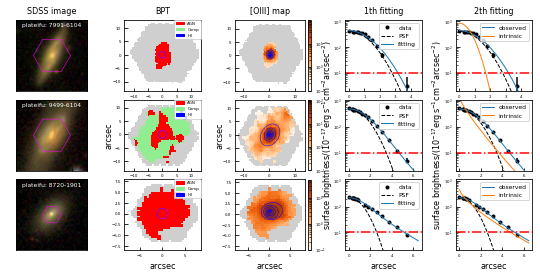

Out of time!


In [11]:
# demo, show the fitting results, used in writing paper
# History:
#    2018-08-03: first edit
#    2018-10-22: update for ppt and paper
#    2019-01-14: update for new data
import warnings
warnings.filterwarnings("ignore") # default or ignore
import matplotlib.backends.backend_pdf as mpdf
from astropy.modeling.models import Gaussian1D
from astropy.io import fits
from scipy import optimize
import scipy as sp
from matplotlib import pyplot as plt
from ppxf import capfit
import matplotlib.backends.backend_pdf as mpdf
from mangatools.fitmaps import FitMaps


def psf_func(r, amplitude=0, mean=0, stddev=0):
    return amplitude * np.exp(-(r-mean)**2/(2*stddev**2))

def psf_kernel(fwhm, interv=1, data_points=50):
    edge = data_points/(2*interv)
    r = np.arange(-edge, edge+interv, interv)
    sigma = fwhm/2.35482
    return np.exp(-r**2/(2*sigma**2))

def fmodel_conv(x, r, basemodel, psf_fwhm=None, points=50, scale_factor=1.5):
    # used for convolution
    r_interp = np.linspace(r.min(), 1.5*r.max(), points)
    flux = basemodel(x, r_interp)
    psf = psf_kernel(psf_fwhm, r_interp[1]-r_interp[0])
    flux_sym = np.array([flux[::-1], flux]).flatten()
    flux_conv = sp.signal.fftconvolve(flux_sym, psf, mode='same')/np.sum(psf)
    return np.interp(r, r_interp, flux_conv[len(flux_sym)//2:])

fm_dir = '/Volumes/Lacie2/fitmaps/fitmap/'
fm_binned_dir = '/Volumes/Lacie2/fitmaps/fitmap2/'

#targets = ['8241-9102', '8464-6101', '8720-1901'] 9499-12703
targets = ['7991-6104', '9499-6104', '8720-1901']

pdf = mpdf.PdfPages('results/checkfitting_example-{}.pdf'.format(today))
SB = 10
err_list = []
fs = 4

fig = plt.figure(figsize=(8, 4))
ax0 = fig.subplots(1, 5)

for i in range(5):
    ax0[i].spines['top'].set_color('none')
    ax0[i].spines['bottom'].set_color('none')
    ax0[i].spines['left'].set_color('none')
    ax0[i].spines['right'].set_color('none')
    ax0[i].tick_params(axis='both', labelcolor='w', top='off', bottom='off', left='off', right='off', labelsize=2)

ax = fig.subplots(3, 5)
plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.1, hspace=0.12, wspace=0.45)

if True:
    for i in range(len(targets)):
        plateifu = targets[i]
        print("====================================================")
        print("plateifu: {}".format(plateifu))
        m = Maps(plateifu)
        psf = m.psf
        fm = FitMaps(plateifu, fitmaps_dir=fm_dir, fitmaps_binned_dir=fm_binned_dir)
        sb_corr = (1+m.z)**4
        
        with fits.open('data/Ellipse_Fitting-2019-05-16.fits') as f:
            data = f[plateifu].data
            header = f[plateifu].header
            # ignore the first point
            r = data['sma']
            I = data['intens'] * 4 * sb_corr
            I_err = data['intens_err'] * 4 * sb_corr
            logI = np.log(I)
            logI_err = I_err/I

        # define the model
        baseModel = lambda x, r: np.exp(x[0] - x[1] * r**(1/x[2]))

        # initial value and bounds
        x0 = (logI[1], 1, 0.5)
        bounds=((0, np.inf), (0.01, 10), (0.5, 10))

        #*********** fit with de-convolution ****************#
        cost_fun2 = lambda x, r, logy, logy_err, basemodel, psf_fwhm: \
                    np.sum((np.log(fmodel_conv(x, r, basemodel, psf_fwhm)) - logy)**2/logy_err**2)
        res_lsq2 = optimize.minimize(cost_fun2, x0,
                                     args=(r, logI, logI_err, baseModel, psf), 
                                     method='L-BFGS-B', options={'disp':False},
                                     jac='2-point', bounds=bounds)
        #print('sol:', res_lsq2.x)
        if True: # save fitted results into file
            r_extend = np.linspace(r.min(), 2*r.max(), 100)
            #gg_fit1 = baseModel(res_lsq1.x, r_extend)
            gg_fit2 = fmodel_conv(res_lsq2.x, r_extend, baseModel, psf)
            gg_fit2_orig = baseModel(res_lsq2.x, r_extend)
            #R_fsb1 = np.max(r_extend[gg_fit1 > SB])
            R_fsb2 = np.max(r_extend[gg_fit2 > SB])
            R_fsb2_orig = np.max(r_extend[gg_fit2_orig > SB])
            print('The difference between origin and observe: {}'.format((R_fsb2-R_fsb2_orig)/R_fsb2))

        if True: # plot to files
            #m.image(showImage=False, mini=True, ax=ax[i, 0], fs=fs)
            m.image_quary(ax=ax[i, 0], scale=0.06, width=640, height=640, show_bundle=True, lw=0.5, opt='', fs=fs+2)
            m.bpt2d(showImage=False, mini=True, ax=ax[i, 1], fs=fs, show_psf=True, show_bundle=True)
            O3_corr, O3_corr_err = fm.O3map()
            isolist = fitEllipse(O3_corr, ax=ax[i, 2], n=3, mini=True, showContour=False, fs=fs, 
                                 quiet=1, plot=True)
            m.bundle_edge(ax[i, 2])
            r_extend = np.linspace(r.min(), 1.2*r.max(), 50) # for smooth plot
            gauss_psf = psf_func(r_extend, amplitude=I.max(), mean=0, stddev=psf/2.35482)
            gg_fit2 = fmodel_conv(res_lsq2.x, r_extend, baseModel, psf)
            gg_fit2_orig = baseModel(res_lsq2.x, r_extend)
            if 1:
                # the components that fit with convolution
                ax[i,3].tick_params(axis='both', which='major', labelsize=fs)
                ax[i,3].tick_params(axis='both', which='minor', labelsize=fs-1)
                ax[i,3].semilogy(r, I, 'ko', label='data', ms=3)
                ax[i,3].errorbar(r, I, yerr=I_err, marker='None', linestyle='None',
                                 color='k')
                ax[i,3].plot(r_extend, gauss_psf, 'k--', label='PSF', lw=1)
                ax[i,3].plot(r_extend, gg_fit2, label='fitting', lw=1)
                ax[i, 3].axhline(y=SB, linestyle='-.', color='r')
                ax[i,3].legend(loc='upper right', fontsize=fs+2)
                #ax[i,3].set_ylabel(r'flux/(10$^{-17}$erg/s)', fontsize=fs+2)
                ax[i,3].set_ylim(0.8 * I.min(), 2*I.max())
            if 1:
                # check the origin and the after convolution
                #ax[i,5].set_title('with convolution', fontsize=fs)
                ax[i,4].tick_params(axis='both', which='major', labelsize=fs)
                ax[i,4].tick_params(axis='both', which='minor', labelsize=fs-1)
                ax[i,4].semilogy(r, I, 'ko', ms=3)
                ax[i,4].errorbar(r, I, yerr=I_err, marker='None', linestyle='None', color='k')
                ax[i,4].plot(r_extend, gauss_psf, 'k--', label=None, lw=1)
                ax[i,4].plot(r_extend, gg_fit2, label='observed', lw=1)
                ax[i,4].plot(r_extend, gg_fit2_orig, label='intrinsic', lw=1)
                #ax[i,5].set_ylim(y.min(), y_fit.max())
                ax[i,4].axhline(y=SB, linestyle='-.', color='r')
                ax[i,4].legend(loc='upper right', fontsize=fs+2)
                #plt.suptitle("{}: {}".format(i, plateifu))
                #ax[i,3].set_ylim(0.8 * I.min(), 2*I.max())
    fs = fs+4
    ax[0, 0].set_title('SDSS image', fontsize=fs)
    ax[0, 1].set_title('BPT', fontsize=fs)
    ax[0, 2].set_title('[OIII] map', fontsize=fs)
    ax[0, 3].set_title('1th fitting', fontsize=fs)
    ax[0, 4].set_title('2th fitting', fontsize=fs)
    ax[2, 1].set_xlabel('arcsec', fontsize=fs)
    ax[2, 2].set_xlabel('arcsec', fontsize=fs)
    ax[2, 3].set_xlabel('arcsec', fontsize=fs)
    ax[2, 4].set_xlabel('arcsec', fontsize=fs)
    ax[0, 3].set_ylim(2, 5*I.max())
    ax[1, 3].set_ylim(2, 5*I.max())
    ax[2, 3].set_ylim(2, 5*I.max())
    ax[0, 4].set_ylim(2, 5*I.max())
    ax[1, 4].set_ylim(2, 5*I.max())
    ax[2, 4].set_ylim(2, 5*I.max())
    
    ax0[1].set_ylabel('arcsec', fontsize=fs)
    ax0[2].set_ylabel('arcsec', fontsize=fs)
    ax0[3].set_ylabel(r'surface brightness/${\rm (10^{-17}erg\,s^{-1}cm^{-2}arcsec^{-2})}$', fontsize=fs)
    ax0[4].set_ylabel(r'surface brightness/${\rm (10^{-17}erg\,s^{-1}cm^{-2}arcsec^{-2})}$', fontsize=fs)
    plt.show(fig)
    #fig.savefig('./results/psf_demo.pdf', bbox_inches='tight')
set_matplotlib_formats('png')

## Testing possible effects drived by the Sersic profile

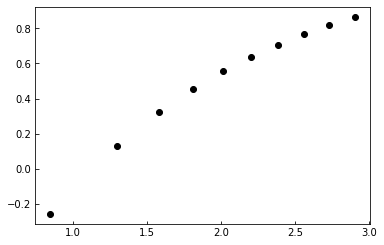

In [18]:
r = np.linspace(0, 5000, 100000)
I_peak = np.linspace(2.6, 6, 10)

k = 0.5
n = 1

r_list = []
L_I = []
SB = 10

for lnI0 in I_peak:
    I_profile = np.exp(lnI0 - k * r**(1/n))
    select = I_profile > SB
    r_list.append(np.max(r[select]))
    L_I.append(np.sum(I_profile[select] * (r[1]-r[0])))
    
plt.plot(np.log10(L_I), np.log10(r_list), 'ko')

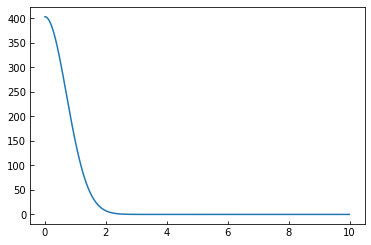

In [33]:
plt.plot(r, np.exp(6 - 1 * r**(1/0.5)))

In [41]:
r[I_profile > 10]

array([0.        , 0.1010101 , 0.2020202 , 0.3030303 , 0.4040404 ,
       0.50505051, 0.60606061, 0.70707071, 0.80808081, 0.90909091,
       1.01010101, 1.11111111, 1.21212121, 1.31313131, 1.41414141,
       1.51515152, 1.61616162, 1.71717172, 1.81818182, 1.91919192])

[ 0.5275042  -0.57291281]


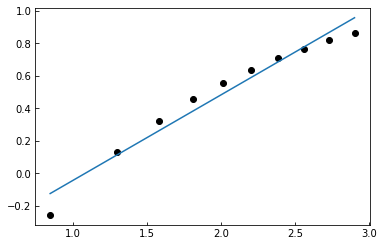

In [19]:
from scipy.optimize import curve_fit

def func(x, a, b):
    return a * x + b

popt, pcov = curve_fit(func, np.log10(L_I), np.log10(r_list))
print(popt)
plt.plot(np.log10(L_I), np.log10(r_list), 'ko')
plt.plot(np.log10(L_I), func(np.log10(L_I), *popt))

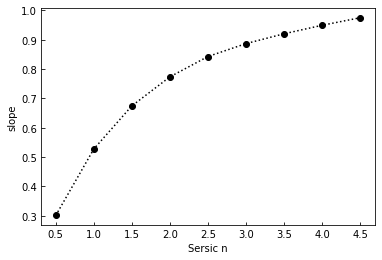

In [20]:
def func(x, a, b):
    return a * x + b

r = np.linspace(0, 5000, 100000)
I_peak = np.linspace(2.6, 6, 10)

k = 0.5
n = 4

SB = 10
slope_list = []
n_list = np.arange(0.5, 5, 0.5)
k_list = [0.2, 0.4, 0.6]
#for k in k_list:
if True:
    for n in n_list:
        r_list = []
        L_I = []
        for lnI0 in I_peak:
            I_profile = np.exp(lnI0 - k * r**(1/n))
            select = I_profile > SB
            r_list.append(np.max(r[select]))
            L_I.append(np.sum(I_profile[select] * (r[1]-r[0])))
        popt, pcov = curve_fit(func, np.log10(L_I), np.log10(r_list))
        slope_list.append(popt[0])
        #print(popt)
    plt.plot(n_list, slope_list, 'ko', linestyle=':')
    plt.xlabel('Sersic n')
    plt.ylabel('slope')

 ## Compare IFU and longslit

Finding the different between IFU and longslit; two direction are chosed for longslit: the major and minor axis of the galaxy

In [31]:
def psf_func(r, amplitude=0, mean=0, stddev=0):
    return amplitude * np.exp(-(r-mean)**2/(2*stddev**2))

/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap/9893-6102.fits' mode='rb' closefd=True>
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap2/9893-6102_binned-maps.fits' mode='rb' closefd=True>


init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
[0.11781818 0.35345455 0.58909091 0.82472727 1.06036364 1.296
 1.53163636 1.76727273 2.00290909 2.23854545 2.47418182]
[0.66684019        nan 0.64400948        nan 0.50069231 0.60838773
 0.46902725 0.3017371  0.34704553 0.23005576 0.08203327]
[0.                nan 0.0187213         nan 0.0202041  0.03123198
 0.10484326 0.00521713 0.1357069  0.14397747 0.08203327]
3.2872390060516663 0.09799355589549298


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

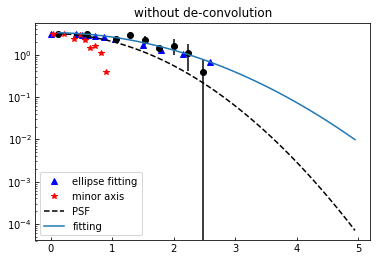

In [51]:
from mangatools.fitmaps import FitMaps
from scipy import optimize, signal

fm_dir = '/Volumes/Lacie2/fitmaps/fitmap/' #set to your local folder
fm_binned_dir = '/Volumes/Lacie2/fitmaps/fitmap2/' #set to your local folder

set_matplotlib_formats('png')
quiet = True
SB = 1

if True:
    plateifu = '9893-6102'
    m = Maps(plateifu)
    agn, cp, sf, *others = m.bptregion()
    r, rr, phi = m.maps['SPX_ELLCOO'].data
    z = m.z
    sb_corr = (1+z)**4
    psf = m.psf

    fm = FitMaps(plateifu, fitmaps_dir=fm_dir, fitmaps_binned_dir=fm_binned_dir)
    O3_corr, O3_corr_err = fm.O3map()
    O3_agn = np.zeros(agn.shape)
    O3_agn[agn] = O3_corr[agn]

    sample_time = 0
    intens_list = []
    agn = binary_opening(binary_closing(agn, iterations=2), iterations=2)

    O3_agn = np.zeros(agn.shape)
    O3_agn[agn] = O3_corr[agn]
    init0, isolist = fitEllipse(O3_agn, init='auto')
    valid = (isolist.stop_code == 0) #& (isolist.valid == 1)

    sma_base = isolist.sma[valid] * 0.5
    intens = isolist.intens[valid].tolist()


    # for major axis
    major_sma, major_intens, major_intens_err = fit_rings(r, O3_agn, np.max(sma_base), 
                                                          step=np.max(sma_base)/len(sma_base))
    # for minor axis
    minor_sma = major_sma * m.elpetro_ba
    
    print(major_sma)
    print(major_intens)
    print(major_intens_err)

    if True: # fitting SB of the major axis
        major_valid = ~(np.isnan(major_intens) & np.isnan(major_intens))
        r = major_sma[major_valid]
        I = major_intens[major_valid] * sb_corr * 4
        I_err = major_intens_err[major_valid] * sb_corr * 4
        logI = np.log(I)
        logI_err = I_err/I + eps
        # define the model
        baseModel = lambda x, r: np.exp(x[0] - x[1] * r**(1/x[2]))

        # initial value and bounds
        x0 = (logI[1], 1, 0.5)
        bounds=((0, np.inf), (0.01, 10), (0.5, 10))

        #********* fit without de-convlolution *************#
        # used the logscale of y, to optimize the fitting
        cost_fun = lambda x, r, logy, logy_err: \
                    np.sum((np.log(baseModel(x, r)) - logy)**2/(logy_err)**2)

        res_lsq = optimize.minimize(cost_fun, x0,
                                     args=(r, logI, logI_err), 
                                     method='L-BFGS-B', options={'disp':False},
                                     jac='2-point', bounds=bounds)
    if True: # calculate the size
        r_extend = np.linspace(r.min(), 2*r.max(), 100) # for smooth plot
        gg_fit = baseModel(res_lsq.x, r_extend)
        
        try:
            R_fsb = np.max(r_extend[gg_fit > SB])
            has_size = True
        except:
            print('No valid measurment')
            R_fsb = 1e-6
            has_size = False
        logR_fsb = np.log10(R_fsb * m.arcsec2kpc.value*1000)
        logR_fsb_err = .5/R_fsb/np.log(10)
        print(logR_fsb, logR_fsb_err)
    if True: #plot the results
        r_extend = np.linspace(r.min(), 2 * r.max(), 100) # for smooth plot
        gauss_psf = psf_func(r_extend, amplitude=I.max(), mean=0, stddev=psf/2.35482)

        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
        
        ax.plot(sma_base, 4*sb_corr*np.array(intens), 'b^', label='ellipse fitting')
        ax.semilogy(r, I, 'ko')
        ax.errorbar(r, I, yerr=I_err, marker='None', linestyle='None', color='k')
        ax.plot(r*m.elpetro_ba, I, 'r*', label='minor axis')

        # show the results of without de-convolution
        gg_fit = baseModel(res_lsq.x, r_extend)
        ax.set_title('without de-convolution')
        ax.plot(r_extend, gauss_psf, 'k--', label='PSF')
        ax.plot(r_extend, gg_fit, label='fitting')
        #ax.axhline(y=SB, linestyle='-.', color='r')
        ax.legend()
        #ax.set_xlim(0, 1.2*r.max())
        #ax.set_ylim(0.8*I.min(), 2*I.max())



In [47]:
major_valid

array([False,  True, False,  True, False, False, False, False, False,
       False, False])

In [73]:
# find different between IFU and longslit
# two direction was chosed for longslit, the major and minor axis
from mangatools.fitmaps import FitMaps
from scipy import optimize, signal

fm_dir = '/Volumes/Lacie2/fitmaps/fitmap/' #set to your local folder
fm_binned_dir = '/Volumes/Lacie2/fitmaps/fitmap2/' #set to your local folder

set_matplotlib_formats('png')
quiet = False
SB = 10

major_R = []
major_R_err = []
minor_R = []
minor_R_err = []

targets = Table.read('data/AGNs-2019-04-26.dat', format='ascii')
targets = targets[:]

for idx, plateifu in enumerate(targets['plateifu']):
    eps = 1e-8 # error value, or value used for handling zero
    if not quiet:
        print(idx, plateifu)
    m = Maps(plateifu)
    agn, cp, sf, *others = m.bptregion()
    r, rr, phi = m.maps['SPX_ELLCOO'].data
    z = m.z
    sb_corr = (1+z)**4
    psf = m.psf

    fm = FitMaps(plateifu, fitmaps_dir=fm_dir, fitmaps_binned_dir=fm_binned_dir)
    O3_corr, O3_corr_err = fm.O3map()
    O3_agn = np.zeros(agn.shape)
    O3_agn[agn] = O3_corr[agn]

    sample_time = 0
    intens_list = []
    agn = binary_opening(binary_closing(agn, iterations=2), iterations=2)

    O3_agn = np.zeros(agn.shape)
    O3_agn[agn] = O3_corr[agn]
    init0, isolist = fitEllipse(O3_agn, init='auto')
    valid = (isolist.stop_code == 0) #& (isolist.valid == 1)

    sma_base = isolist.sma[valid] * 0.5
    intens = isolist.intens[valid].tolist()


    # for major axis
    major_sma, major_intens, major_intens_err = fit_rings(r, O3_agn, np.max(sma_base), 
                                                          step=np.max(sma_base)/len(sma_base))
    # for minor axis
    minor_sma = major_sma * m.elpetro_ba

    if True: # fitting SB of the major axis
        major_valid = ~(np.isnan(major_intens) & np.isnan(major_intens))
        r = major_sma[major_valid]
        I = major_intens[major_valid] * sb_corr * 4
        I_err = major_intens_err[major_valid] * sb_corr * 4
        logI = np.log(I)
        logI_err = I_err/I + eps
        # define the model
        baseModel = lambda x, r: np.exp(x[0] - x[1] * r**(1/x[2]))

        # initial value and bounds
        x0 = (logI[1], 1, 0.5)
        bounds=((0, np.inf), (0.01, 10), (0.5, 10))

        #********* fit without de-convlolution *************#
        # used the logscale of y, to optimize the fitting
        cost_fun = lambda x, r, logy, logy_err: \
                    np.sum((np.log(baseModel(x, r)) - logy)**2/(logy_err)**2)

        res_lsq = optimize.minimize(cost_fun, x0,
                                     args=(r, logI, logI_err), 
                                     method='L-BFGS-B', options={'disp':False},
                                     jac='2-point', bounds=bounds)
    if True: # calculate the size
        r_extend = np.linspace(r.min(), 2*r.max(), 100) # for smooth plot
        gg_fit = baseModel(res_lsq.x, r_extend)
        
        try:
            R_fsb = np.max(r_extend[gg_fit > SB])
            has_size = True
        except:
            print('No valid measurment')
            R_fsb = 1e-6
            has_size = False
        logR_fsb = np.log10(R_fsb * m.arcsec2kpc.value*1000)
        logR_fsb_err = .5/R_fsb/np.log(10)
        if not quiet:
            print(logR_fsb, logR_fsb_err)
        major_R.append(logR_fsb)
        major_R_err.append(logR_fsb_err)
        minor_R.append(logR_fsb * m.elpetro_ba)
        minor_R_err.append(logR_fsb_err * m.elpetro_ba)

0 7495-1902
init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
2.8823319080401926 0.18668383356528997
1 7815-6104


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.565131928222052 0.09720547602581786
2 7991-6104


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap/7815-6104.fits' mode='rb' closefd=True>
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap2/7815-6104_binned-maps.fits' mode='rb' closefd=True>


init: auto
guess initial value by given range
Success: [3.0, 0.2, 1.0]
3.0638574934379834 0.10906736768662142
3 7991-3702


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
2.993096716445885 0.12125465249694838
4 8132-6101


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap/7991-3702.fits' mode='rb' closefd=True>
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap2/7991-3702_binned-maps.fits' mode='rb' closefd=True>


init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.679905776502557 0.11828999106670515
5 8247-6101


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.5]
2.7985151361446627 0.17446543203929854
6 8137-3702


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.661598321669966 0.1257773408806134
7 8141-1901


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap/8137-3702.fits' mode='rb' closefd=True>
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap2/8137-3702_binned-maps.fits' mode='rb' closefd=True>


init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.0941417571164616 0.11266815323953538
8 8143-6101


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap/8141-1901.fits' mode='rb' closefd=True>
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap2/8141-1901_binned-maps.fits' mode='rb' closefd=True>


init: auto
guess initial value by given range


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Success: [3.0, 0.4, 1.0]
3.6628431395087824 0.12004807641253462
9 8256-12704


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap/8143-6101.fits' mode='rb' closefd=True>
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap2/8143-6101_binned-maps.fits' mode='rb' closefd=True>
/Users/hang/Desktop/research/projects/ENLR/code_new/mangatools/fitmaps.py:54: RuntimeWarning: invalid value encountered in true_divide
  snr_cut = ((Ha / Ha_err) < 3) | ((Hb / Hb_err) < 3)
/Users/hang/Desktop/research/projects/ENLR/code_new/mangatools/fitmaps.py:54: RuntimeWarning: invalid value encountered in less
  snr_cut = ((Ha / Ha_err) < 3) | ((Hb / Hb_err) < 3)
/Users/hang/Desktop/research/projects/ENLR/code_new/mangatools/fitmaps.py:58: RuntimeWarning: divide by zero encountered in log10
  E_BV = 1.97 * np.log10(ratio_obs / ratio_theory)


init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.671492140138776 0.11762851044561728
10 8249-3704


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.029516345160051 0.11231455315503736
11 8319-12705


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap/8249-3704.fits' mode='rb' closefd=True>
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap2/8249-3704_binned-maps.fits' mode='rb' closefd=True>


init: auto
guess initial value by given range
Success: [3.0, 0.2, 1.0]
3.2407073327495226 0.15520595519609393
12 8341-12704


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.100477844615887 0.1078119361477045
13 8439-6104


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 1.5]
3.1405409340181194 0.12232770251904528
14 8452-1901


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
2.880626225735897 0.15206854108528184
15 8483-12703


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap/8452-1901.fits' mode='rb' closefd=True>
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap2/8452-1901_binned-maps.fits' mode='rb' closefd=True>


init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.1229221492905794 0.1951486642539122
16 8482-12704


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.5]
3.3024056089414158 0.13355584912707358
17 8549-12701


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 1.0]
3.2149692729314716 0.1144593798411178
18 8465-12704


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap/8549-12701.fits' mode='rb' closefd=True>
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap2/8549-12701_binned-maps.fits' mode='rb' closefd=True>
/Users/hang/Desktop/research/projects/ENLR/code_new/mangatools/fitmaps.py:54: RuntimeWarning: invalid value encountered in true_divide
  snr_cut = ((Ha / Ha_err) < 3) | ((Hb / Hb_err) < 3)
/Users/hang/Desktop/research/projects/ENLR/code_new/mangatools/fitmaps.py:54: RuntimeWarning: invalid value encountered in less
  snr_cut = ((Ha / Ha_err) < 3) | ((Hb / Hb_err) < 3)
/Users/hang/Desktop/research/projects/ENLR/code_new/mangatools/fitmaps.py:58: RuntimeWarning: divide by zero encountered in log10
  E_BV = 1.97 * np.log10(ratio_obs / ratio_theory)


init: auto
guess initial value by given range


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Success: [3.0, 0.2, 0.0]
3.2495337667737414 0.13985033007005265
19 8552-12701


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap/8465-12704.fits' mode='rb' closefd=True>
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap2/8465-12704_binned-maps.fits' mode='rb' closefd=True>


init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
2.993239294113961 0.12894982408297379
20 8552-9102


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.2135237140638853 0.3276570165250872
21 8318-3704


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
2.921371969583369 0.13305997344962156
22 8318-6102


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Success: [3.0, 0.2, 0.0]
3.658302517889286 0.12402230821716298
23 8464-6101


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap/8318-6102.fits' mode='rb' closefd=True>
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap2/8318-6102_binned-maps.fits' mode='rb' closefd=True>
/Users/hang/Desktop/research/projects/ENLR/code_new/mangatools/fitmaps.py:54: RuntimeWarning: invalid value encountered in true_divide
  snr_cut = ((Ha / Ha_err) < 3) | ((Hb / Hb_err) < 3)
/Users/hang/Desktop/research/projects/ENLR/code_new/mangatools/fitmaps.py:54: RuntimeWarning: invalid value encountered in less
  snr_cut = ((Ha / Ha_err) < 3) | ((Hb / Hb_err) < 3)
/Users/hang/Desktop/research/projects/ENLR/code_new/mangatools/fitmaps.py:58: RuntimeWarning: divide by zero encountered in log10
  E_BV = 1.97 * np.log10(ratio_obs / ratio_theory)


init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.744431260704682 0.0990391122748872
24 8320-3704


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.2910730497867444 0.06319099604412394
25 8550-3704


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.014134640372087 0.12935769286177143
26 8606-12701


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.3224542047792003 0.133944092874536
27 8314-3704


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap/8606-12701.fits' mode='rb' closefd=True>
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap2/8606-12701_binned-maps.fits' mode='rb' closefd=True>


init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
2.92267773427905 0.17218523149790882
28 8611-3704


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap/8314-3704.fits' mode='rb' closefd=True>
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap2/8314-3704_binned-maps.fits' mode='rb' closefd=True>


init: auto
guess initial value by given range
Success: [3.0, 0.2, 2.5]
2.960973430696997 0.14268934590608637
29 7992-9102


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.6197483339025958 0.1256639125877465
30 8603-6101


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Success: [3.0, 0.2, 0.0]
2.8418496838098557 0.20088277008089356
31 8612-12704


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap/8603-6101.fits' mode='rb' closefd=True>
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap2/8603-6101_binned-maps.fits' mode='rb' closefd=True>
/Users/hang/Desktop/research/projects/ENLR/code_new/mangatools/fitmaps.py:54: RuntimeWarning: invalid value encountered in true_divide
  snr_cut = ((Ha / Ha_err) < 3) | ((Hb / Hb_err) < 3)
/Users/hang/Desktop/research/projects/ENLR/code_new/mangatools/fitmaps.py:54: RuntimeWarning: invalid value encountered in less
  snr_cut = ((Ha / Ha_err) < 3) | ((Hb / Hb_err) < 3)
/Users/hang/Desktop/research/projects/ENLR/code_new/mangatools/fitmaps.py:58: RuntimeWarning: divide by zero encountered in log10
  E_BV = 1.97 * np.log10(ratio_obs / ratio_theory)


init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.885325669289315 0.0199883631580806
32 8588-12704


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap/8612-12704.fits' mode='rb' closefd=True>
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap2/8612-12704_binned-maps.fits' mode='rb' closefd=True>


init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.060697407657382 0.11822328618452467
33 8602-12701


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
2.951268405117226 0.13430327605468226
34 8077-6103


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap/8602-12701.fits' mode='rb' closefd=True>
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap2/8602-12701_binned-maps.fits' mode='rb' closefd=True>


init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.5]
3.1697051964728544 0.1427358548193543
35 8147-6102


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.2170490865146992 0.17024153210571552
36 8146-12705


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
2.8584586800757252 0.3918092512656495
37 8084-6103


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: overflow encountered in exp
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap/8146-12705.fits' mode='rb' closefd=True>
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap2/8146-12705_binned-maps.fits' mode='rb' closefd=True>


init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
2.961928233918374 0.17446543203929854
38 8718-12702


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.502771535717393 0.054662672581608125
39 8718-12701


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.24816002031646 0.1256639125877465
40 8725-9102


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.2764837831036497 0.11570847556659465
41 10001-6102


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.0481671254857448 0.10471992715645542
42 8715-3702


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.443111651338662 0.08726660596371286
43 8255-6101


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.265147456882781 0.14115421253474078
44 8241-9102


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.364192202583678 0.1277072282395798
45 8241-6102


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.2257974866167247 0.09901884229693494
46 8720-1901


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
2.907108743103891 0.1262238876529706
47 8547-12701


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap/8720-1901.fits' mode='rb' closefd=True>
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap2/8720-1901_binned-maps.fits' mode='rb' closefd=True>


init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.9313614783621165 0.02345876504400883
48 8978-12705


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap/8547-12701.fits' mode='rb' closefd=True>
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap2/8547-12701_binned-maps.fits' mode='rb' closefd=True>


init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
2.9153284749481316 0.15571184162111373
49 8978-6102


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
No valid measurment
-3.26395057353054 217147.2409516259
50 8978-9101


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
2.9073828044527934 0.16811793711063377
51 8979-6102


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap/8978-9101.fits' mode='rb' closefd=True>
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap2/8978-9101_binned-maps.fits' mode='rb' closefd=True>


init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
2.9936650179902706 0.15722878162637474
52 8948-12704


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.407092004482572 0.1257830253010998
53 8946-3701


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.2883493799660726 0.12217522606264758
54 8947-3701


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.2515797428474107 0.11822328618452467
55 8945-3703


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.0657025744045194 0.17453321192742569
56 8597-3703


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap/8945-3703.fits' mode='rb' closefd=True>
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap2/8945-3703_binned-maps.fits' mode='rb' closefd=True>


init: auto
guess initial value by given range


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Success: [3.0, 0.2, 2.0]
3.0090293613804 0.15707989073468315
57 9026-9101


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap/8597-3703.fits' mode='rb' closefd=True>
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap2/8597-3703_binned-maps.fits' mode='rb' closefd=True>


init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.102718577705835 0.11102835650322984
58 9049-1901


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap/9026-9101.fits' mode='rb' closefd=True>
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap2/9026-9101_binned-maps.fits' mode='rb' closefd=True>


init: auto
guess initial value by given range


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Success: [3.0, 0.2, 0.0]
3.7139090977499785 0.11106266687297743
59 9002-12702


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap/9049-1901.fits' mode='rb' closefd=True>
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap2/9049-1901_binned-maps.fits' mode='rb' closefd=True>


init: auto
guess initial value by given range
Success: [3.0, 0.4, 2.0]
3.1003069907121246 0.19339671751874246
60 9031-1902


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.5]
3.1384243823054483 0.1394575301115024
61 9027-12704


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.16244500308437 0.10665918506676017
62 8982-3703


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap/9027-12704.fits' mode='rb' closefd=True>
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap2/9027-12704_binned-maps.fits' mode='rb' closefd=True>


init: auto
guess initial value by given range
Success: [3.0, 0.2, 1.0]
3.3244653555755774 0.09932784418633983
63 7972-6103


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap/8982-3703.fits' mode='rb' closefd=True>
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap2/8982-3703_binned-maps.fits' mode='rb' closefd=True>


init: auto
guess initial value by given range


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Success: [3.0, 0.2, 0.0]
3.1567050721015955 0.13430327605468226
64 9025-12704


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap/7972-6103.fits' mode='rb' closefd=True>
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap2/7972-6103_binned-maps.fits' mode='rb' closefd=True>


init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.516311252120299 0.06552441403418713
65 7958-9101


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap/9025-12704.fits' mode='rb' closefd=True>
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap2/9025-12704_binned-maps.fits' mode='rb' closefd=True>


init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.0946390186339414 0.13895402271482754
66 9195-3703


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.5]
3.071856967473404 0.10221254861890648
67 8080-12703


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 1.5]
2.8135591353917127 0.15707989073468312
68 9182-6102


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap/8080-12703.fits' mode='rb' closefd=True>
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap2/8080-12703_binned-maps.fits' mode='rb' closefd=True>
/Users/hang/Desktop/research/projects/ENLR/code_new/mangatools/fitmaps.py:54: RuntimeWarning: invalid value encountered in true_divide
  snr_cut = ((Ha / Ha_err) < 3) | ((Hb / Hb_err) < 3)
/Users/hang/Desktop/research/projects/ENLR/code_new/mangatools/fitmaps.py:54: RuntimeWarning: invalid value encountered in less
  snr_cut = ((Ha / Ha_err) < 3) | ((Hb / Hb_err) < 3)
/Users/hang/Desktop/research/projects/ENLR/code_new/mangatools/fitmaps.py:58: RuntimeWarning: divide by zero encountered in log10
  E_BV = 1.97 * np.log10(ratio_obs / ratio_theory)


init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.4329542310587695 0.10779807738480952
69 9193-12701


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
2.787205316408459 0.09996667897930363
70 8940-12702


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap/9193-12701.fits' mode='rb' closefd=True>
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap2/9193-12701_binned-maps.fits' mode='rb' closefd=True>


init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.1119421370880493 0.09259800632805544
71 9183-3703


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.420052287354361 0.03980159797569735
72 8993-12705


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap/9183-3703.fits' mode='rb' closefd=True>
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap2/9183-3703_binned-maps.fits' mode='rb' closefd=True>


init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.1790555572705017 0.08721154816815213
73 8992-3702


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
2.930968334571883 0.1387854456290373
74 9485-12705


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap/8992-3702.fits' mode='rb' closefd=True>
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap2/8992-3702_binned-maps.fits' mode='rb' closefd=True>
/Users/hang/Desktop/research/projects/ENLR/code_new/mangatools/fitmaps.py:54: RuntimeWarning: invalid value encountered in true_divide
  snr_cut = ((Ha / Ha_err) < 3) | ((Hb / Hb_err) < 3)
/Users/hang/Desktop/research/projects/ENLR/code_new/mangatools/fitmaps.py:54: RuntimeWarning: invalid value encountered in less
  snr_cut = ((Ha / Ha_err) < 3) | ((Hb / Hb_err) < 3)
/Users/hang/Desktop/research/projects/ENLR/code_new/mangatools/fitmaps.py:58: RuntimeWarning: divide by zero encountered in log10
  E_BV = 1.97 * np.log10(ratio_obs / ratio_theory)


init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.5]
3.1542736207164825 0.10138453524906132
75 9487-3702


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.50774663014615 0.0744546111823367
76 8989-3703


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap/9487-3702.fits' mode='rb' closefd=True>
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap2/9487-3702_binned-maps.fits' mode='rb' closefd=True>


init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.0460434158195184 0.10658516758926762
77 8984-9102


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.5]
2.886914525045465 0.15599658114340942
78 8983-12701


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
2.9668990198799268 0.12275480493391251
79 8311-6104


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.1106861643499206 0.09153603092714052
80 8309-12701


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.839191068305784 0.04343937719082595
81 9507-12704


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Success: [3.4000000000000004, 0.2, 1.5]
2.856536640506432 0.11359399859556078
82 9507-12705


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap/9507-12704.fits' mode='rb' closefd=True>
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap2/9507-12704_binned-maps.fits' mode='rb' closefd=True>


init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.5]
3.029572853682183 0.117918791935612
83 9508-12704


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.423631823938868 0.13495026273829858
84 9508-3704


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.050729404410475 0.11453116316155353
85 9024-12705


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.5458810739671494 0.07611917305506326
86 9488-3702


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
2.8073019127354097 0.15998877760014024
87 9502-9101


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.195209701222065 0.24415678668543137
88 9502-12703


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.5]
3.1681396971795257 0.08715655980234625
89 9511-12704


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.5]
3.2480632884527227 0.1183478628822955
90 9511-6104


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.031225610591139 0.1951486642539122
91 8990-12705


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.166758106325667 0.11337787388986316
92 8990-9101


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
2.8149882367904606 0.20308871627662373
93 8442-9102


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.339094990601343 0.047310064502100256
94 9048-1902


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.3464779701360383 0.10096379168940886
95 9095-12701


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap/9048-1902.fits' mode='rb' closefd=True>
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap2/9048-1902_binned-maps.fits' mode='rb' closefd=True>
/Users/hang/Desktop/research/projects/ENLR/code_new/mangatools/fitmaps.py:54: RuntimeWarning: invalid value encountered in true_divide
  snr_cut = ((Ha / Ha_err) < 3) | ((Hb / Hb_err) < 3)
/Users/hang/Desktop/research/projects/ENLR/code_new/mangatools/fitmaps.py:54: RuntimeWarning: invalid value encountered in less
  snr_cut = ((Ha / Ha_err) < 3) | ((Hb / Hb_err) < 3)
/Users/hang/Desktop/research/projects/ENLR/code_new/mangatools/fitmaps.py:58: RuntimeWarning: divide by zero encountered in log10
  E_BV = 1.97 * np.log10(ratio_obs / ratio_theory)


init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.39645337602315 0.15510517210830418
96 9196-12703


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.5]
3.4206239224811026 0.1374937302913887
97 9881-1901


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 1.0]
2.889212494957263 0.16308069554926652
98 9883-12701


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.312608549411881 0.1406494748133101
99 9888-12701


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap/9883-12701.fits' mode='rb' closefd=True>
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap2/9883-12701_binned-maps.fits' mode='rb' closefd=True>


init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.54707567252778 0.042178483626813916
100 9893-6102


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
No valid measurment
-3.0583177923724567 217147.2409516259
101 8656-12705


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Success: [3.0, 0.2, 1.5]
3.2353644983756227 0.15146866518356475
102 8656-12702


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap/8656-12705.fits' mode='rb' closefd=True>
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap2/8656-12705_binned-maps.fits' mode='rb' closefd=True>


init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.1357127955487316 0.19925088842741787
103 9498-3703


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.0874365610845147 0.10692650132006032
104 10216-3704


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap/9498-3703.fits' mode='rb' closefd=True>
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap2/9498-3703_binned-maps.fits' mode='rb' closefd=True>


init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
2.977306487751589 0.13527876710958472
105 10216-12704


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap/10216-3704.fits' mode='rb' closefd=True>
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap2/10216-3704_binned-maps.fits' mode='rb' closefd=True>


init: auto
guess initial value by given range


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Success: [3.0, 0.2, 1.0]
3.2398695609347072 0.11543201847051966
106 10218-1902


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap/10216-12704.fits' mode='rb' closefd=True>
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap2/10216-12704_binned-maps.fits' mode='rb' closefd=True>
/Users/hang/Desktop/research/projects/ENLR/code_new/mangatools/fitmaps.py:54: RuntimeWarning: invalid value encountered in true_divide
  snr_cut = ((Ha / Ha_err) < 3) | ((Hb / Hb_err) < 3)
/Users/hang/Desktop/research/projects/ENLR/code_new/mangatools/fitmaps.py:54: RuntimeWarning: invalid value encountered in less
  snr_cut = ((Ha / Ha_err) < 3) | ((Hb / Hb_err) < 3)
/Users/hang/Desktop/research/projects/ENLR/code_new/mangatools/fitmaps.py:58: RuntimeWarning: divide by zero encountered in log10
  E_BV = 1.97 * np.log10(ratio_obs / ratio_theory)


init: auto
guess initial value by given range
Success: [3.0, 0.4, 2.5]
3.138666975605612 0.11828999106670515
107 10221-6104


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
2.7091914708248512 0.21787523785332852
108 9503-12701


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.5]
3.0914807299443017 0.10573792166745843
109 9503-6102


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.110639213298642 0.10199616590778171
110 9503-3704


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.048166199144363 0.17511874270292416
111 9499-12703


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.0116531167025826 0.16286954229650527
112 9499-6104


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.5]
3.2598046982435185 0.0685435791129633
113 9499-6101


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap/9499-6104.fits' mode='rb' closefd=True>
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap2/9499-6104_binned-maps.fits' mode='rb' closefd=True>


init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.1215370582836894 0.1529821544546479
114 10215-1902


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.0164807551108503 0.17090789298531303
115 9495-1901


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
2.682959726189737 0.1466850681938028
116 8723-6104


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.1985410111029724 0.12590960396370873
117 9489-6104


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
2.9006369095888673 0.1124585522819155
118 8998-12705


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.392079319393457 0.13102398468864562
119 8981-6104


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 1.5]
3.642561629095844 0.07244827571937777
120 8988-6102


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 1.0]
3.2828998877096476 0.1699975165317465
121 10514-12705


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Success: [3.0, 0.6000000000000001, 1.5]
3.333454544400883 0.04877706634150616
122 10514-9102


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap/10514-12705.fits' mode='rb' closefd=True>
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap2/10514-12705_binned-maps.fits' mode='rb' closefd=True>
/Users/hang/Desktop/research/projects/ENLR/code_new/mangatools/fitmaps.py:54: RuntimeWarning: invalid value encountered in true_divide
  snr_cut = ((Ha / Ha_err) < 3) | ((Hb / Hb_err) < 3)
/Users/hang/Desktop/research/projects/ENLR/code_new/mangatools/fitmaps.py:54: RuntimeWarning: invalid value encountered in less
  snr_cut = ((Ha / Ha_err) < 3) | ((Hb / Hb_err) < 3)
/Users/hang/Desktop/research/projects/ENLR/code_new/mangatools/fitmaps.py:58: RuntimeWarning: divide by zero encountered in log10
  E_BV = 1.97 * np.log10(ratio_obs / ratio_theory)


init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
2.9065325816059153 0.091644400340235
123 10510-12704


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
2.2507788460798137 0.09390645641747362
124 10510-6103


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 1.5]
2.910268138907294 0.1074581867358115
125 10493-3704


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.120586274094959 0.10665918506676017
126 9884-3704


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap/10493-3704.fits' mode='rb' closefd=True>
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap2/10493-3704_binned-maps.fits' mode='rb' closefd=True>


init: auto
guess initial value by given range


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Success: [3.0, 0.2, 0.0]
3.5255807106887778 0.03896225938511787
127 10494-12701


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap/9884-3704.fits' mode='rb' closefd=True>
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap2/9884-3704_binned-maps.fits' mode='rb' closefd=True>


init: auto
guess initial value by given range


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Success: [4.200000000000001, 0.2, 0.0]
3.9330057611230327 0.033244421319509644
128 10508-12703


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap/10494-12701.fits' mode='rb' closefd=True>
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap2/10494-12701_binned-maps.fits' mode='rb' closefd=True>


init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.277522691298628 0.11111760759366653
129 10508-6101


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.0352471066980793 0.12697522031757166
130 10492-12702


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap/10508-6101.fits' mode='rb' closefd=True>
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap2/10508-6101_binned-maps.fits' mode='rb' closefd=True>


init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.094724889460346 0.09793438501303345
131 10492-6103


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.2236728947204365 0.07428608930602797
132 9882-9102


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap/10492-6103.fits' mode='rb' closefd=True>
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap2/10492-6103_binned-maps.fits' mode='rb' closefd=True>


init: auto
guess initial value by given range
Success: [3.0, 0.2, 1.0]
3.2926209334543457 0.12648524534975789
133 9882-3701


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 1.0]
2.93855699406064 0.15471042202516405
134 10503-12703


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap/9882-3701.fits' mode='rb' closefd=True>
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap2/9882-3701_binned-maps.fits' mode='rb' closefd=True>


init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.040195279021968 0.11278204707142936
135 9091-3704


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.2280339025756026 0.10743779307303061
136 9091-12703


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap/9091-3704.fits' mode='rb' closefd=True>
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap2/9091-3704_binned-maps.fits' mode='rb' closefd=True>


init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.6889382616841466 0.03025242340075379
137 8337-1901


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.68014105941907 0.12287138119690769
138 9885-3703


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.0835429088617485 0.11461882574338403
139 8334-3703


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
2.8334724619441722 0.1649047039025946
140 8260-1901


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
2.893454492320097 0.13549307010698608
141 9892-3703


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.3763868505805417 0.11109209264358759
142 8324-6104


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.770124881560022 0.04332162960744983
143 8614-12703


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap/8324-6104.fits' mode='rb' closefd=True>
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap2/8324-6104_binned-maps.fits' mode='rb' closefd=True>
/Users/hang/Desktop/research/projects/ENLR/code_new/mangatools/fitmaps.py:54: RuntimeWarning: invalid value encountered in true_divide
  snr_cut = ((Ha / Ha_err) < 3) | ((Hb / Hb_err) < 3)
/Users/hang/Desktop/research/projects/ENLR/code_new/mangatools/fitmaps.py:54: RuntimeWarning: invalid value encountered in less
  snr_cut = ((Ha / Ha_err) < 3) | ((Hb / Hb_err) < 3)
/Users/hang/Desktop/research/projects/ENLR/code_new/mangatools/fitmaps.py:58: RuntimeWarning: divide by zero encountered in log10
  E_BV = 1.97 * np.log10(ratio_obs / ratio_theory)


init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.0533188767793185 0.10471992715645542
144 8614-3703


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.104152753915813 0.12748512871220655
145 9092-1902


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.2652132065663055 0.11309752132897183
146 9032-12701


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap/9092-1902.fits' mode='rb' closefd=True>
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap2/9092-1902_binned-maps.fits' mode='rb' closefd=True>


init: auto
guess initial value by given range
Success: [3.0, 0.2, 1.0]
3.30276588280886 0.0999235946149384
147 9032-12702


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.3208804331447337 0.11778314915347748
148 8593-12705


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.3049335855637807 0.10151572182750014
149 9090-9102


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap/8593-12705.fits' mode='rb' closefd=True>
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap2/8593-12705_binned-maps.fits' mode='rb' closefd=True>


init: auto
guess initial value by given range
Success: [3.0, 0.2, 0.0]
3.1148620502085644 0.18168276518710333
150 9090-3701


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap/9090-9102.fits' mode='rb' closefd=True>
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:32: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/Lacie2/fitmaps/fitmap2/9090-9102_binned-maps.fits' mode='rb' closefd=True>


init: auto
guess initial value by given range
Success: [3.2, 0.2, 1.5]
3.5291564412184626 0.060719385095272284
151 8651-1902


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/

init: auto
guess initial value by given range


/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/hang/.local/miniconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Success: [3.0, 0.2, 0.5]
3.3297268528175525 0.11158015605159993


Text(0, 0.5, '$R_{16}$ major axis')

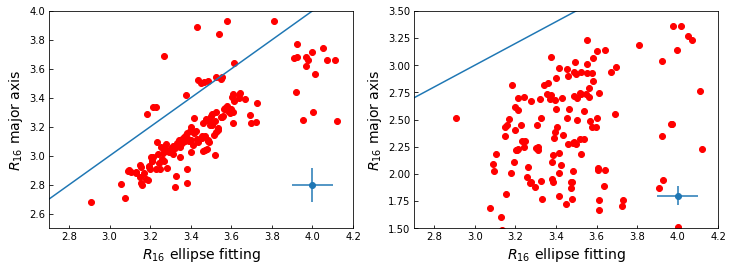

In [84]:
Rdata = Table.read('data/R_fsb(10)-2019-05-03.dat', format='ascii')
R = Rdata['logR_fsb2']
R_err = Rdata['logR_fsb2_err']

fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(121)
ax.plot(R, np.array(major_R), 'ro')
ax.set_xlim(2.7, 4.2)
ax.set_ylim(2.5, 4.0)

x0 = np.linspace(2.7, 4.2)
y0 = x0
ax.plot(x0, y0)

ax.plot(4., 2.8, 'o', color='C0')
ax.errorbar(4., 2.8, xerr=np.median(R_err), yerr=np.median(major_R_err), color='C0')

ax.set_xlabel(r"$R_{16}$ ellipse fitting", fontsize=14)
ax.set_ylabel(r"$R_{16}$ major axis", fontsize=14)

ax = fig.add_subplot(122)
ax.plot(R, np.array(minor_R), 'ro')
ax.set_xlim(2.7, 4.2)
ax.set_ylim(1.5, 3.5)

x0 = np.linspace(2.7, 4.2)
y0 = x0
ax.plot(x0, y0)

ax.plot(4., 1.8, 'o', color='C0')
ax.errorbar(4., 1.8, xerr=np.median(R_err), yerr=np.median(minor_R_err), color='C0')

ax.set_xlabel(r"$R_{16}$ ellipse fitting", fontsize=14)
ax.set_ylabel(r"$R_{16}$ major axis", fontsize=14)

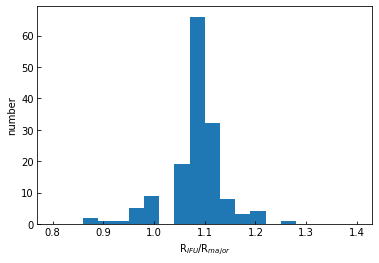

In [109]:
#plt.hist(np.abs(R - major_R) / R, range=(0., 0.3), bins=10)
plt.hist(R / major_R, range=(0.8, 1.4), bins=20)
plt.xlabel(r'R$_{IFU}$/R$_{major}$')
plt.ylabel('number')
plt.savefig('results/response2-1.pdf', bbox_inches='tight')

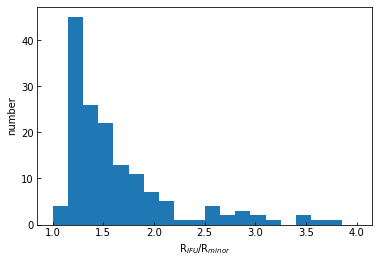

In [108]:
#plt.hist(np.abs(R - minor_R) / R, range=(0., 0.8), bins=10)
plt.hist(R / minor_R, range=(1., 4), bins=20)
plt.xlabel(r'R$_{IFU}$/R$_{minor}$')
plt.ylabel('number')
plt.savefig('results/response2-2.pdf', bbox_inches='tight')